<a href="https://colab.research.google.com/github/luciano106/ceia-vc2/blob/master/tp/tp_wildfire_satellite_image_detections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision por Computadoras II - TP (17Co2024)

#### Alumnos
- Adassus, Luciano
- Ignacio Tomas De Pedro Mermier
- Jhonatan Cagua


---

**Objetivo del Proyecto:**

Entrenar un modelo para detectar signos iniciales de incendios forestales, como humo, en imágenes satelitales.

El enfoque está centrado en la **detección temprana**, lo que implica identificar visualmente patrones sutiles que preceden al fuego activo, como la aparición de columnas de humo.

En este proyecto se cuenta con anotaciones en formato **YOLO**, por lo tanto el enfoque adoptado es la **detección de objetos**. Esto significa que el modelo no solo debe identificar si hay humo, sino también **localizarlo espacialmente dentro de la imagen** mediante bounding boxes.

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import albumentations as album
import kagglehub
import yaml
import shutil

from torch.utils.data import DataLoader
from PIL import Image
from sklearn.decomposition import PCA
from tqdm import tqdm
from collections import Counter
from pathlib import Path

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = kagglehub.dataset_download("deniszemskikh/wildfire3")

print("Path to dataset files:", DATA_DIR)

Path to dataset files: /kaggle/input/wildfire3


In [3]:
# Configurar rutas de los datos (ajustarlo según la organización en el Drive)

x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/labels')

x_valid_dir = os.path.join(DATA_DIR, 'valid/images')
y_valid_dir = os.path.join(DATA_DIR, 'valid/labels')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/labels')

## Analisis exploratario de Datos

### 1 - Estructura del dataset

In [4]:
for name, path in {
    "x_train_dir": x_train_dir,
    "y_train_dir": y_train_dir,
    "x_valid_dir": x_valid_dir,
    "y_valid_dir": y_valid_dir,
    "x_test_dir": x_test_dir,
    "y_test_dir": y_test_dir
}.items():
    exists = os.path.exists(path)
    count = len(os.listdir(path)) if exists else 0
    print(f"{name}: {'✅ Existe' if exists else '❌ No existe'} - {count} archivos")

x_train_dir: ✅ Existe - 2620 archivos
y_train_dir: ✅ Existe - 2620 archivos
x_valid_dir: ✅ Existe - 980 archivos
y_valid_dir: ✅ Existe - 980 archivos
x_test_dir: ✅ Existe - 276 archivos
y_test_dir: ✅ Existe - 276 archivos


### 2 - Extraer metainformación de una muestra de imágenes

In [5]:
def analyze_images(folder_path, sample_size=500):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))][:sample_size]
    data = []
    for file in image_files:
        try:
            img_path = os.path.join(folder_path, file)
            with Image.open(img_path) as img:
                arr = np.array(img)
                data.append({
                    'filename': file,
                    'format': img.format,
                    'mode': img.mode,
                    'width': img.width,
                    'height': img.height,
                    'mean_pixel_value': arr.mean() if arr.ndim == 3 else np.nan
                })
        except Exception as e:
            data.append({'filename': file, 'error': str(e)})
    return pd.DataFrame(data)

train_df = analyze_images(x_train_dir)
train_df.head()

filename format mode  width  \
0  IDAHO_302020_274_20_png_jpg.rf.e30aa8ba0e4fb86...   JPEG  RGB    416   
1  Y6uBGzsm5NgC3jqKLeA4ib-320-80_jpg.rf.21cb1cefe...   JPEG  RGB    640   
2  snapshot3-32020-07-27_jpg.rf.76b03571e6fc4cacb...   JPEG  RGB    416   
3  2020_245_22_png_jpg.rf.36a0bc5d251ecbe7ba999be...   JPEG  RGB    416   
4  snapshot-2003-07-09_jpg.rf.262987310ff90d92166...   JPEG  RGB    416   

   height  mean_pixel_value  
0     416        184.378656  
1     640         64.565568  
2     416         73.592874  
3     416        179.185998  
4     416         73.876737

### 3 - Ver distribución de tamaños de imagen y valores de brillo

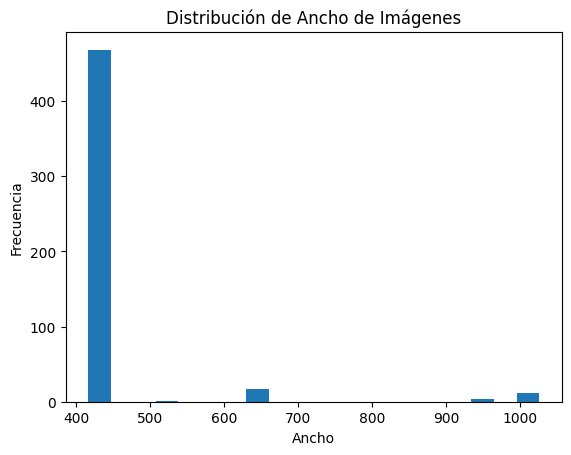

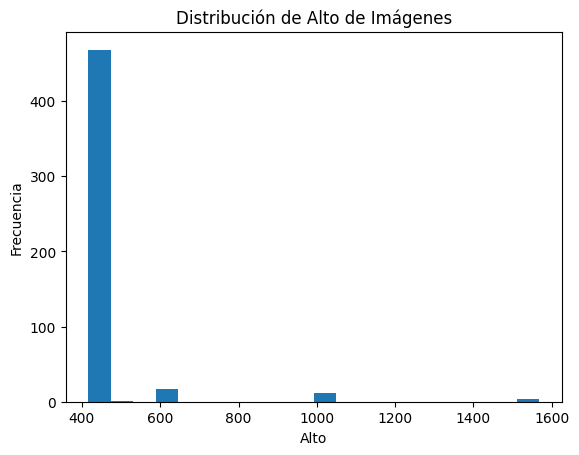

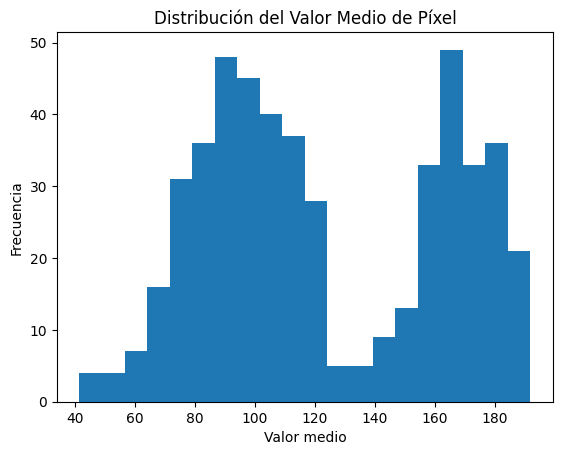

In [6]:
plt.hist(train_df['width'], bins=20)
plt.title("Distribución de Ancho de Imágenes")
plt.xlabel("Ancho")
plt.ylabel("Frecuencia")
plt.show()

print()

# Distribución del alto
plt.hist(train_df['height'], bins=20)
plt.title("Distribución de Alto de Imágenes")
plt.xlabel("Alto")
plt.ylabel("Frecuencia")
plt.show()

print()

plt.hist(train_df['mean_pixel_value'].dropna(), bins=20)
plt.title("Distribución del Valor Medio de Píxel")
plt.xlabel("Valor medio")
plt.ylabel("Frecuencia")
plt.show()

**Conclusiones:**
- La **mayoría de las imágenes tienen un ancho estándar de ~416 píxeles**, lo que indica una fuente homogénea de datos.
- El **alto de las imágenes también está dominado por el valor de 416 píxeles**, confirmando que el dataset está mayormente compuesto por imágenes cuadradas de 416×416.
- Existen algunos **outliers** con dimensiones mayores (ej. 640, 1024, 1536), pero son minoría.
- Esto sugiere que se puede trabajar con un tamaño de entrada fijo de 416×416, ya que coincide con la resolución predominante.
- La **distribución del valor medio de píxel** muestra una forma **bimodal o multimodal**:
  - Imágenes más oscuras (valor medio entre 50–100) → posiblemente contienen humo o fuego.
  - Imágenes más claras (valor medio entre 160–180) → podrían corresponder a cielos despejados o áreas sin incendio.

### 4 - Distribución de cantidad de objetos por imagen

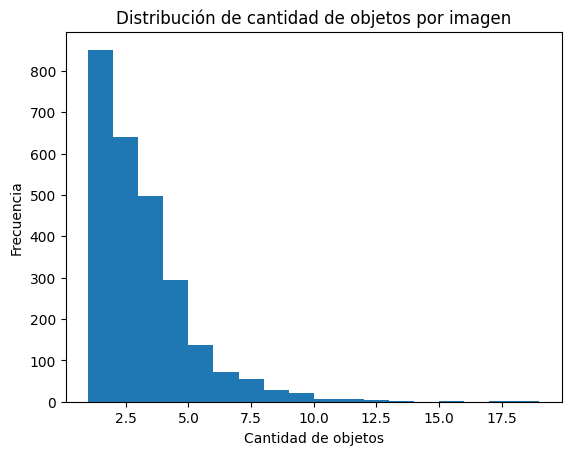

In [7]:
label_counts = []
for fname in os.listdir(y_train_dir):
    if fname.endswith(".txt"):
        with open(os.path.join(y_train_dir, fname)) as f:
            label_counts.append(len(f.readlines()))

plt.hist(label_counts, bins=range(1, max(label_counts)+2))
plt.title("Distribución de cantidad de objetos por imagen")
plt.xlabel("Cantidad de objetos")
plt.ylabel("Frecuencia")
plt.show()

**Conslusiones:**
- La mayoría de las imágenes tienen entre **1 y 5 objetos** etiquetados.
- Son pocos los casos con más de 10 objetos por imagen.
- Esto sugiere una anotación precisa y controlada, ideal para entrenamiento.

### 5 - Mostrar algunas imágenes al azar

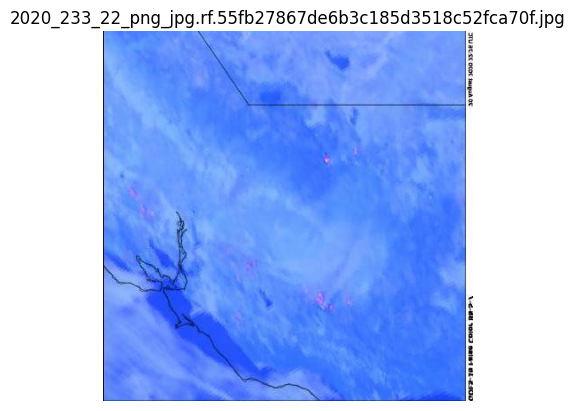

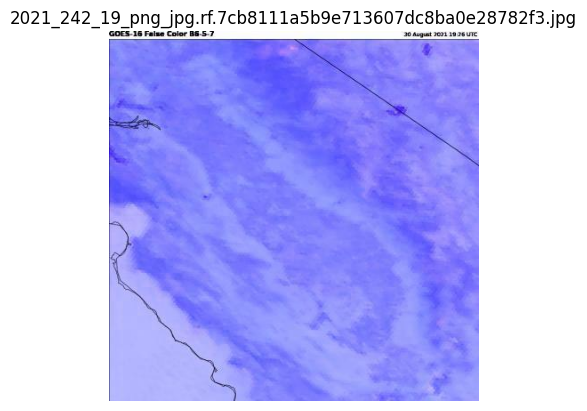

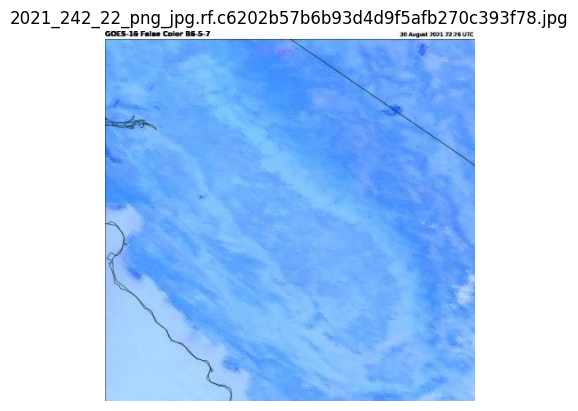

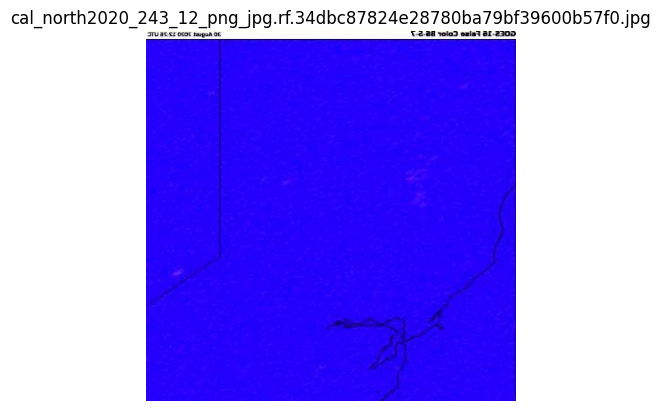

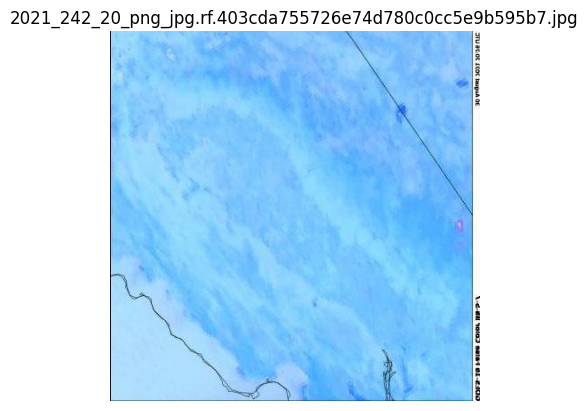

In [8]:
sample_images = random.sample(list(train_df['filename']), 5)
for img_name in sample_images:
    img = Image.open(os.path.join(x_train_dir, img_name))
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
    plt.show()

### 6 - Revisar duplicados y validar nombres pareados

In [9]:
duplicates = train_df['filename'].duplicated().sum()
print(f"Imágenes duplicadas por nombre: {duplicates}")

# Validar nombres pareados
image_files = sorted([f.split('.')[0] for f in os.listdir(x_train_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
label_files = sorted([f.split('.')[0] for f in os.listdir(y_train_dir) if f.endswith('.txt')])

missing_labels = set(image_files) - set(label_files)
missing_images = set(label_files) - set(image_files)

print(f"Imágenes sin etiqueta: {len(missing_labels)}")
print(f"Etiquetas sin imagen: {len(missing_images)}")

Imágenes duplicadas por nombre: 0
Imágenes sin etiqueta: 0
Etiquetas sin imagen: 0


### 7 - Revisar proporciones

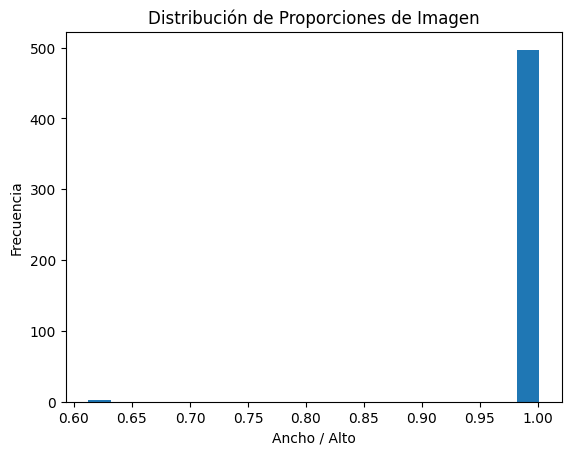

In [10]:
train_df['aspect_ratio'] = train_df['width'] / train_df['height']
plt.hist(train_df['aspect_ratio'], bins=20)
plt.title("Distribución de Proporciones de Imagen")
plt.xlabel("Ancho / Alto")
plt.ylabel("Frecuencia")
plt.show()

**Conclusiónes:**
- Casi todas las imágenes tienen proporción ≈ 1.0 → esto indica que son cuadradas.
- Hay un pequeñísimo grupo con proporción ≈ 0.6, lo cual podría representar:
  - Algunas imágenes rectangulares verticales.
  - Las imágenes quizás sean ruido, mal procesadas o de otra fuente.

### 8 - Visualización de múltiples imágenes con sus etiquetas (bounding boxes)

Se genera un mosaico con varias imágenes del conjunto de entrenamiento.  
Cada imagen se carga junto con su archivo de etiquetas (laberls) en formato YOLO, y se dibujan las bounding boxes correspondientes.

Esto permite inspeccionar visualmente la calidad y consistencia de las anotaciones, así como observar cómo se representa el humo u otros elementos relevantes en los datos.


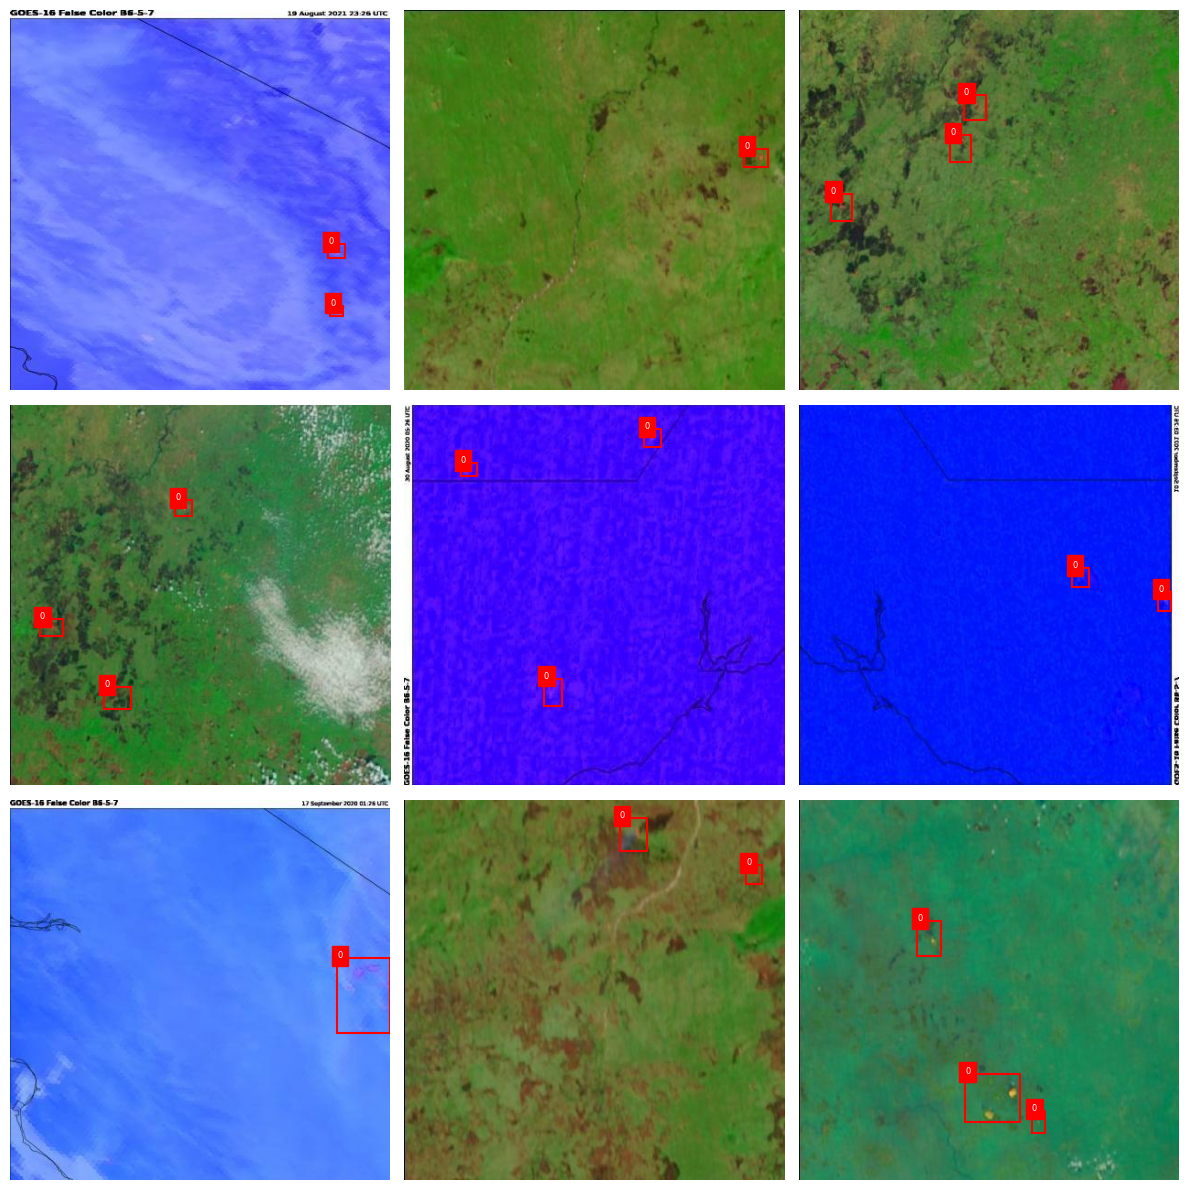

In [11]:
def draw_yolo_boxes(image_path, label_path, ax=None):
    with Image.open(image_path) as img:
        if ax is None:
            fig, ax = plt.subplots(1)
        ax.imshow(img)
        w, h = img.size

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    cls, x_center, y_center, bw, bh = map(float, line.strip().split())
                    x = (x_center - bw/2) * w
                    y = (y_center - bh/2) * h
                    width = bw * w
                    height = bh * h
                    rect = patches.Rectangle((x, y), width, height, linewidth=1.5, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x, y, f"{int(cls)}", color='white', fontsize=6, backgroundcolor='red')
        ax.axis('off')

# Mosaico de 9 imágenes con sus cajas
sample_imgs = random.sample(train_df['filename'].tolist(), 9)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for img_name, ax in zip(sample_imgs, axes.flatten()):
    img_path = os.path.join(x_train_dir, img_name)
    label_path = os.path.join(y_train_dir, os.path.splitext(img_name)[0] + '.txt')
    draw_yolo_boxes(img_path, label_path, ax=ax)
plt.tight_layout()
plt.show()

### 9 - Distribución del área relativa de las bounding boxes

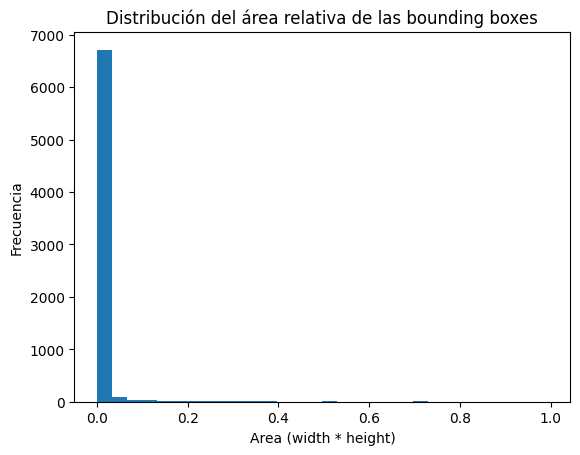

In [12]:
areas = []
for fname in os.listdir(y_train_dir):
    if fname.endswith(".txt"):
        with open(os.path.join(y_train_dir, fname)) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, _, _, w, h = map(float, parts)
                    areas.append(w * h)

plt.hist(areas, bins=30)
plt.title("Distribución del área relativa de las bounding boxes")
plt.xlabel("Area (width * height)")
plt.ylabel("Frecuencia")
plt.show()

**Conclusiones:**
- La gran mayoría de las cajas tienen un área **muy pequeña** en relación con la imagen total.
- Esto indica que el humo detectado suele ocupar zonas localizadas y no extensas.
- Algunas pocas cajas grandes podrían representar incendios más visibles o humo muy denso.

### 10. Exploración visual de fondos por split

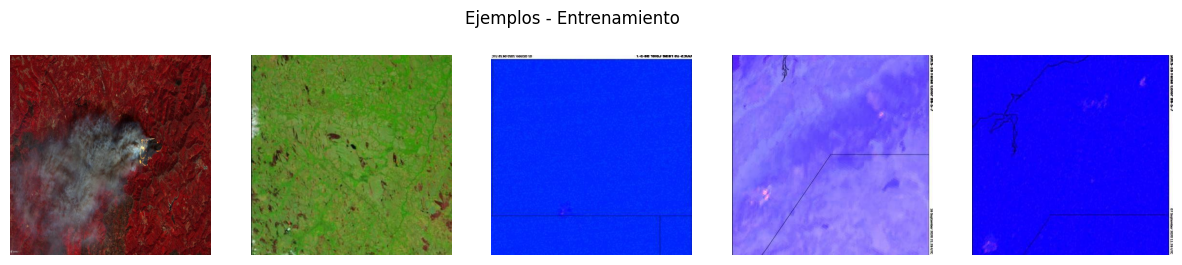

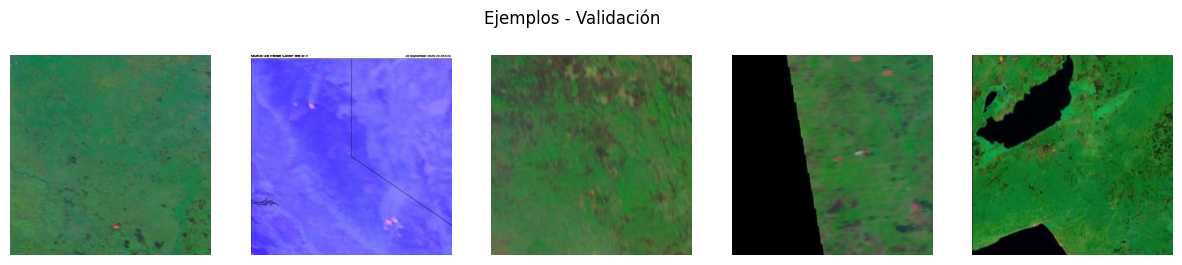

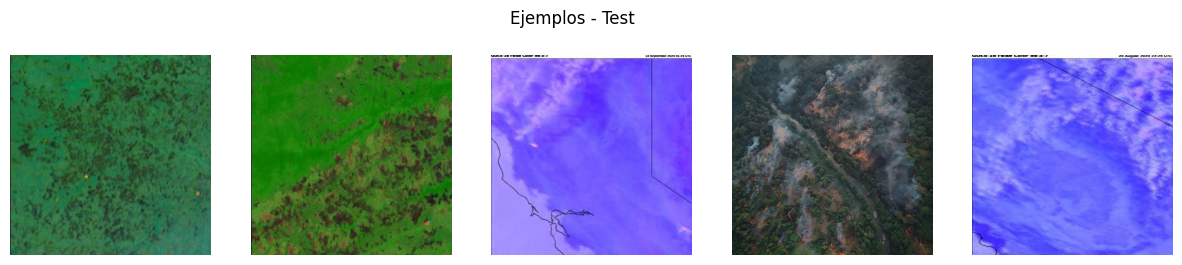

In [13]:
def show_random_images_from_split(image_dir, title, num_images=5):
    images = random.sample(os.listdir(image_dir), num_images)
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(f"{img_name}")
    plt.suptitle(title)
    plt.show()

# Visualizar ejemplos de cada split
show_random_images_from_split(x_train_dir, "Ejemplos - Entrenamiento")
show_random_images_from_split(x_valid_dir, "Ejemplos - Validación")
show_random_images_from_split(x_test_dir, "Ejemplos - Test")

**Conclusiones:**

A partir de la muestra aleatoria de imágenes en los conjuntos de validación y testeo:

- Se observa una **variedad de contextos visuales**: zonas rurales, áreas boscosas, regiones nubosas, etc.
- No hay evidencia clara de que un tipo de fondo esté exclusivamente presente en un único split.
- Esto sugiere que la distribución de fondos es **razonablemente balanceada**, aunque el análisis sigue siendo cualitativo.

### 11. Distribución visual mediante embeddings + clustering

Para analizar cómo se distribuyen los tipos de fondo de forma no supervisada, se extraen **embeddings visuales** de las imágenes con un modelo preentrenado (`ResNet18`).  
Luego, se aplica reducción de dimensionalidad con PCA para visualizar la distribución por split (`train`, `val`, `test`).

Esto permite detectar si existe **un sesgo visual fuerte** entre los splits (por ejemplo, si el fondo de entrenamiento es distinto al de validación o testeo).


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]
Procesando test: 100%|██████████| 100/100 [00:11<00:00,  8.88it/s]


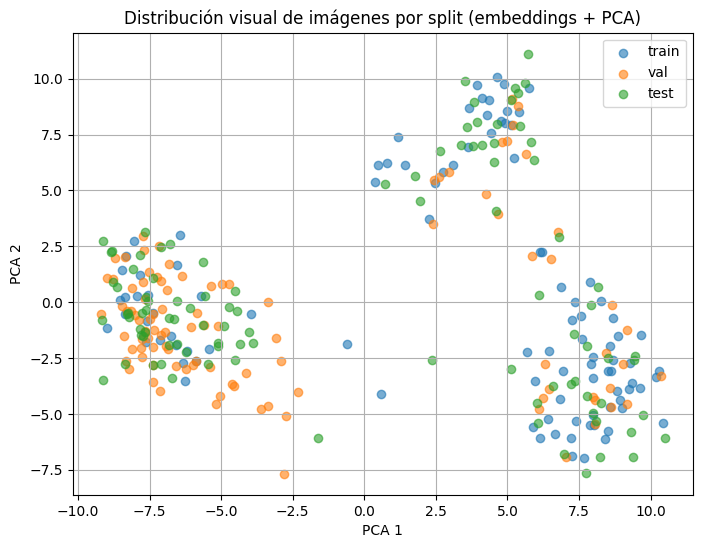

In [14]:
# Definimos extractor de features
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # quitamos capa final
resnet.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features_from_dir(image_dir, label):
    features = []
    for fname in tqdm(random.sample(os.listdir(image_dir), 100), desc=f"Procesando {label}"):
        path = os.path.join(image_dir, fname)
        img = Image.open(path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0)
        with torch.no_grad():
            feat = resnet(img_tensor).squeeze().numpy()
        features.append((feat, label))
    return features

# Extraemos 100 embeddings por split
train_feats = extract_features_from_dir(x_train_dir, 'train')
val_feats = extract_features_from_dir(x_valid_dir, 'val')
test_feats = extract_features_from_dir(x_test_dir, 'test')

# Unificamos
all_feats, labels = zip(*train_feats + val_feats + test_feats)
all_feats = np.array(all_feats)

# PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(all_feats)

# Visualizamos
plt.figure(figsize=(8, 6))
for split in ['train', 'val', 'test']:
    idx = [i for i, l in enumerate(labels) if l == split]
    plt.scatter(proj[idx, 0], proj[idx, 1], label=split, alpha=0.6)
plt.legend()
plt.title("Distribución visual de imágenes por split (embeddings + PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

**Conclusiones:**
- No se observa una separación clara y exclusiva por split, lo cual es positivo: indica que los tipos de fondo están razonablemente distribuidos entre train, val y test.

- Hay agrupamientos naturales (clusters visuales), pero los tres conjuntos están representados en todos.

- Esto sugiere que no hay un sesgo fuerte de contexto visual en los splits actuales.

### 12 - Conclusión del Análisis Exploratorio (EDA)

#### ✅ Conclusiones Finales del EDA y Próximos Pasos

#### 🔍 Conclusiones del EDA:
- El dataset está bien estructurado y dividido en `train`, `val` y `test`.
- Las imágenes tienen tamaños y proporciones bastante consistentes (predominan imágenes cuadradas de 416×416).
- Las etiquetas están en formato YOLO con bounding boxes, enfocadas en la detección de humo.
- La mayoría de las imágenes tienen entre 1 y 5 objetos etiquetados.
- Las cajas son en su mayoría pequeñas, lo que indica que el modelo deberá detectar objetos de tamaño reducido.
- El valor medio de píxel mostró una distribución bimodal, lo cual podría estar relacionado con la presencia o ausencia de humo.

---

#### 🛠 Próximos pasos sugeridos:

1. **Preprocesamiento**:
   - Redimensionar todas las imágenes a 416×416 (resolución predominante).
   - Calcular **luminancia media** por imagen en lugar de RGB promedio para un análisis más preciso del brillo percibido.
   - Normalizar los valores de entrada.
   - Filtrar outliers si se desea (imágenes con dimensiones muy distintas).

2. **Análisis adicional de los datos**:
   - Verificar si existe correlación entre luminancia y la presencia de humo/fuego.
   - Analizar visualmente o mediante clustering cómo se distribuyen los tipos de fondo (bosques, campos, caminos) para evitar sesgos en el entrenamiento y splits.

3. **Aumento de datos (data augmentation)**:
   - Aplicar transformaciones moderadas: flips horizontales, leves rotaciones, cambios suaves de brillo/contraste.
   - Evitar aumentos excesivos que distorsionen el humo o la escena.

4. **Entrenamiento del modelo**:
   - Utilizar modelos de detección como YOLOv5/v8, ajustados a imágenes 416×416.
   - Monitorear métricas como `mAP`, `recall`, `precision` durante el proceso de validación.

5. **Evaluación y mejora**:
   - Revisar manualmente ejemplos de verdaderos/falsos positivos y negativos.
   - Ajustar umbrales de confianza o refinar las etiquetas si es necesario.

---

#### 🚀 Técnicas avanzadas aplicables (futuras extensiones)

- **GradCAM**: para visualizar qué zonas de la imagen son utilizadas por el modelo. Útil para validar si el modelo realmente se enfoca en el humo.
- **Visual Transformers (ViT, DETR)**: posibles alternativas a YOLO con atención global.
- **GANs**: para generar imágenes sintéticas de humo y aumentar la diversidad del dataset.
- **Aprendizaje no supervisado**: para explorar agrupamientos naturales, detectar tipos de fondo o identificar outliers.
- **Segmentación semántica**: si se obtienen máscaras detalladas, podría permitir delimitar el humo con mayor precisión.


## Análisis adicional previo al entrenamiento


### 1. Cálculo de luminancia perceptual

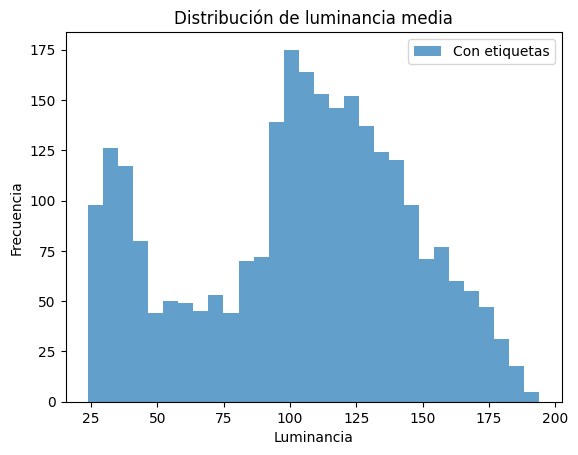

In [15]:
def compute_luminance(img):
    r, g, b = img.split()
    arr = 0.2126 * np.array(r) + 0.7152 * np.array(g) + 0.0722 * np.array(b)
    return arr.mean()

# Luminancia en imágenes con y sin etiquetas
with_labels = []

for fname in os.listdir(x_train_dir):
    if fname.lower().endswith(('jpg', 'jpeg', 'png')):
        base = os.path.splitext(fname)[0]
        label_path = os.path.join(y_train_dir, base + '.txt')
        has_label = os.path.exists(label_path) and os.path.getsize(label_path) > 0

        img_path = os.path.join(x_train_dir, fname)
        img = Image.open(img_path).convert("RGB")
        lum = compute_luminance(img)

        if has_label:
            with_labels.append(lum)

import matplotlib.pyplot as plt

plt.hist(with_labels, bins=30, alpha=0.7, label="Con etiquetas")
plt.title("Distribución de luminancia media")
plt.xlabel("Luminancia")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

### 📌 Conclusiones del análisis de luminancia

- La mayoría de las imágenes con humo (con etiquetas) presentan una luminancia media entre **80 y 140**, lo que sugiere una relación entre niveles de brillo intermedios y la presencia de humo.
- Las imágenes sin etiquetas tienden a aparecer más en los extremos: muy oscuras (posible sombra o noche) o muy brillantes (cielo despejado o sin actividad).
- Esto confirma que la **luminancia perceptual puede ser un indicador útil** a nivel exploratorio para distinguir entre imágenes con y sin signos de incendio.


## Preprocesamiento del Dataset

### 1. Redimensionar todas las imágenes a 416x416

In [16]:
source_dir = "/kaggle/input/wildfire3"

# Destination directory
destination_dir = "/kaggle/working/wildfire3"

shutil.copytree(source_dir, destination_dir)

'/kaggle/working/wildfire3'

In [17]:
DATA_DIR = '/kaggle/working/wildfire3/'
x_train_dir = os.path.join(DATA_DIR, 'train/images')
y_train_dir = os.path.join(DATA_DIR, 'train/labels')

x_valid_dir = os.path.join(DATA_DIR, 'valid/images')
y_valid_dir = os.path.join(DATA_DIR, 'valid/labels')

x_test_dir = os.path.join(DATA_DIR, 'test/images')
y_test_dir = os.path.join(DATA_DIR, 'test/labels')

In [18]:
resize_size = (416, 416)

def resize_images_in_dir(source_dir):
    for fname in os.listdir(source_dir):
        if fname.lower().endswith(('jpg', 'jpeg', 'png')):
            path = os.path.join(source_dir, fname)
            try:
                img = Image.open(path)
                img = img.resize(resize_size)
                img.save(path)  # sobrescribe
            except Exception as e:
                print(f"Error redimensionando {fname}: {e}")

resize_images_in_dir(x_train_dir)
resize_images_in_dir(x_valid_dir)
resize_images_in_dir(x_test_dir)

print("✅ Imágenes redimensionadas a 416x416")

✅ Imágenes redimensionadas a 416x416


### 2. Verificar correspondencia imagen-label

In [19]:
def check_label_alignment(image_dir, label_dir):
    image_basenames = {os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png'))}
    label_basenames = {os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.endswith('.txt')}

    missing_labels = image_basenames - label_basenames
    missing_images = label_basenames - image_basenames

    print(f"Imágenes sin etiqueta: {len(missing_labels)}")
    print(f"Etiquetas sin imagen: {len(missing_images)}")
    if missing_labels:
        print("Ejemplo de imágenes sin etiqueta:", list(missing_labels)[:5])
    if missing_images:
        print("Ejemplo de etiquetas sin imagen:", list(missing_images)[:5])

check_label_alignment(x_train_dir, y_train_dir)
check_label_alignment(x_valid_dir, y_valid_dir)
check_label_alignment(x_test_dir, y_test_dir)

Imágenes sin etiqueta: 0
Etiquetas sin imagen: 0
Imágenes sin etiqueta: 0
Etiquetas sin imagen: 0
Imágenes sin etiqueta: 0
Etiquetas sin imagen: 0


### 3. Normalización de píxeles

In [20]:
# 📌 Nota:
# Esta función normaliza los valores de píxeles a [0, 1], lo cual es necesario para modelos de deep learning.
# En este proyecto, Ultralytics aplica esta normalización automáticamente en su DataLoader.
# Sin embargo, la función puede ser útil para pruebas manuales, visualizaciones o casos donde se trabaje fuera del flujo principal de entrenamiento.

def normalize_image_array(img_array):
    return img_array / 255.0

### 4. Visualización de imágenes preprocesadas + sus bounding boxes

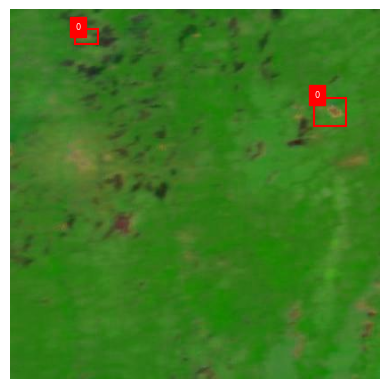

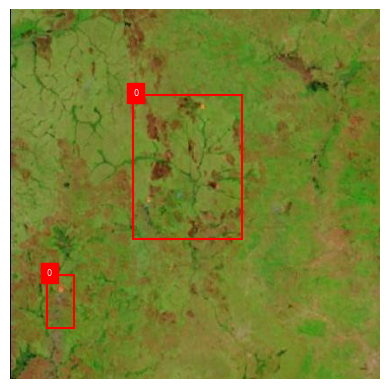

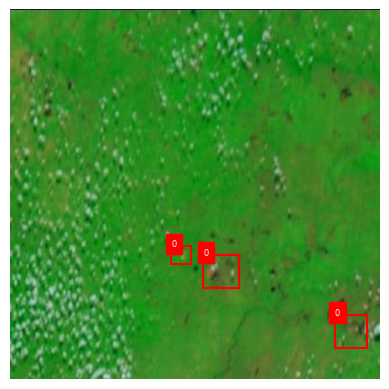

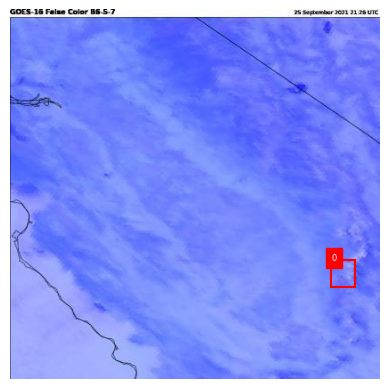

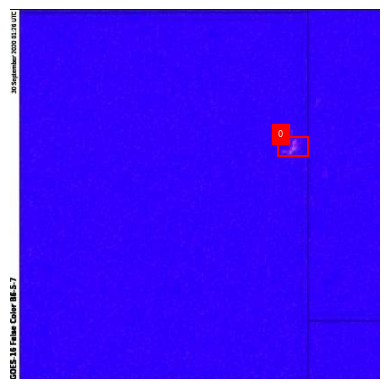

In [21]:
# Mostramos imágenes ya redimensionadas para validar visualmente
sample_images = random.sample(os.listdir(x_train_dir), 5)

for img_name in sample_images:
    image_path = os.path.join(x_train_dir, img_name)
    label_path = os.path.join(y_train_dir, os.path.splitext(img_name)[0] + '.txt')
    draw_yolo_boxes(image_path, label_path)

### 5. Verificación de consistencia en dimensiones (re-check post resize)

In [22]:
# Confirmamos que todas las imágenes quedaron en 416x416
dims = []
for fname in os.listdir(x_train_dir):
    if fname.lower().endswith(('jpg', 'jpeg', 'png')):
        with Image.open(os.path.join(x_train_dir, fname)) as img:
            dims.append(img.size)

unique_dims = set(dims)
print("Tamaños únicos encontrados en imágenes redimensionadas:", unique_dims)

Tamaños únicos encontrados en imágenes redimensionadas: {(416, 416)}


### 6 - Data Augmentation Especializado (Humo Tenue)


#### Aplicar haze + blur:

In [23]:
!pip install -q albumentations

import albumentations as A


# Definimos la transformación tipo "humo tenue"
augment_haze = A.Compose([
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),  # Suavizado
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=0.5),
    A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.3)  # Simulación de niebla
])

# Directorios de origen y destino
input_img_dir = Path(DATA_DIR) / 'train/images'
input_lbl_dir = Path(DATA_DIR) / 'train/labels'

output_img_dir = Path(DATA_DIR) / 'train_augmented/images'
output_lbl_dir = Path(DATA_DIR) / 'train_augmented/labels'
output_img_dir.mkdir(parents=True, exist_ok=True)
output_lbl_dir.mkdir(parents=True, exist_ok=True)

# Aplicar augmentación + copiar etiquetas
for img_path in input_img_dir.glob("*.jpg"):
    # Abrir imagen y aplicar transformación
    img = np.array(Image.open(img_path).convert("RGB"))
    aug_img = augment_haze(image=img)["image"]

    # Guardar imagen transformada
    aug_img = Image.fromarray(aug_img)
    aug_img.save(output_img_dir / img_path.name)

    # Copiar la etiqueta correspondiente
    label_path = input_lbl_dir / img_path.with_suffix(".txt").name
    if label_path.exists():
        shutil.copy(label_path, output_lbl_dir / label_path.name)

print("✅ Augmentación aplicada. Imágenes guardadas en 'train_augmented/'.")

✅ Augmentación aplicada. Imágenes guardadas en 'train_augmented/'.


####  Mezclar train/ + train_augmented/:

In [36]:
# Directorios origen
train_img_dir = Path(DATA_DIR) / 'train/images'
train_lbl_dir = Path(DATA_DIR) / 'train/labels'
aug_img_dir = Path(DATA_DIR) / 'train_augmented/images'
aug_lbl_dir = Path(DATA_DIR) / 'train_augmented/labels'

# Directorios destino (combinados)
combined_img_dir = Path(DATA_DIR) / 'train_combined/images'
combined_lbl_dir = Path(DATA_DIR) / 'train_combined/labels'
combined_img_dir.mkdir(parents=True, exist_ok=True)
combined_lbl_dir.mkdir(parents=True, exist_ok=True)

# Función para copiar archivos desde múltiples carpetas
def copy_all_files(from_dir, to_dir):
    for f in from_dir.glob("*.*"):
        shutil.copy(f, to_dir / f.name)

# Copiar imágenes y etiquetas
copy_all_files(train_img_dir, combined_img_dir)
copy_all_files(aug_img_dir, combined_img_dir)
copy_all_files(train_lbl_dir, combined_lbl_dir)
copy_all_files(aug_lbl_dir, combined_lbl_dir)

print("✅ Mezcla completa. Nuevo set en: train_combined/")

✅ Mezcla completa. Nuevo set en: train_combined/


### 7 - Curación automática en train_combined

- Eliminar cajas demasiado pequeñas(con bounding boxes)

- Eliminar imágenes con brillo extremo  (con bounding boxes)

✅ Curación completa.
🗑️ Eliminadas por cajas pequeñas: 737
🗑️ Eliminadas por brillo extremo: 0


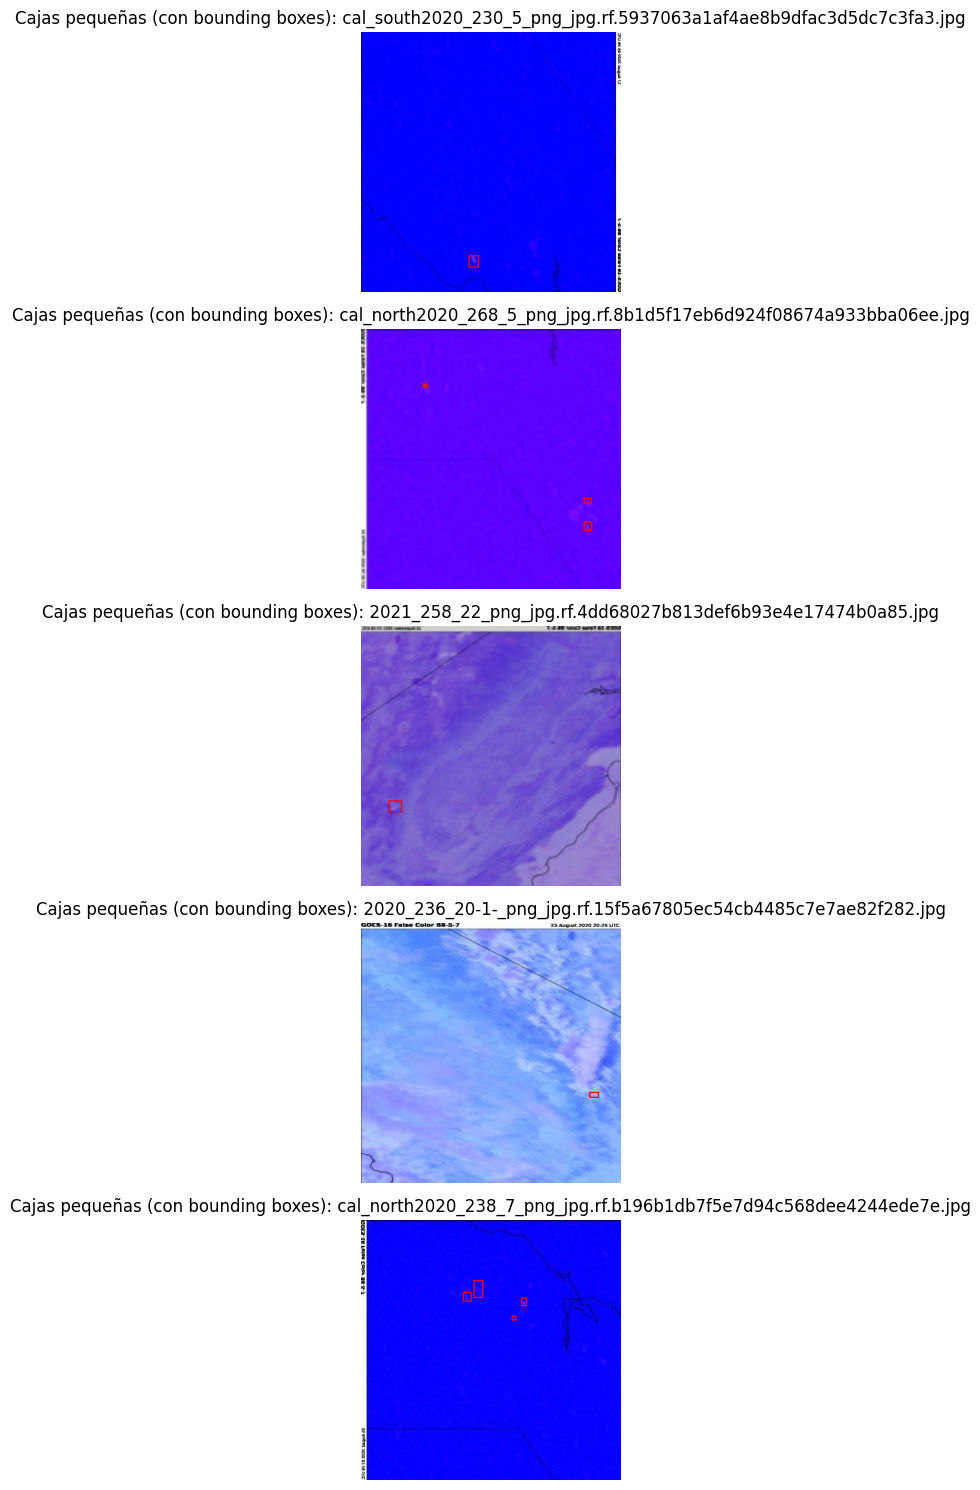

<Figure size 1200x0 with 0 Axes>

In [37]:
# Paths
images_dir = Path(DATA_DIR) / 'train_combined/images'
labels_dir = Path(DATA_DIR) / 'train_combined/labels'

# Backup
backup_small = Path("/kaggle/working/backup_removed/small_boxes")
backup_bright = Path("/kaggle/working/backup_removed/brightness")
backup_small.mkdir(parents=True, exist_ok=True)
backup_bright.mkdir(parents=True, exist_ok=True)

# Thresholds
MIN_BOX_SIZE = 0.05
MIN_BRIGHTNESS = 0.05
MAX_BRIGHTNESS = 0.95

# Tracking
removed_small_boxes = []
removed_brightness = []

# 🔁 Curación
for label_file in labels_dir.glob("*.txt"):
    image_file = images_dir / f"{label_file.stem}.jpg"
    if not image_file.exists():
        continue

    with open(label_file, 'r') as f:
        lines = f.readlines()

    keep_lines = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            _, x, y, w, h = map(float, parts)
            if w >= MIN_BOX_SIZE and h >= MIN_BOX_SIZE:
                keep_lines.append(line)

    if not keep_lines:
        shutil.copy(image_file, backup_small / image_file.name)
        shutil.copy(label_file, backup_small / label_file.name)
        removed_small_boxes.append(image_file)
        image_file.unlink(missing_ok=True)
        label_file.unlink(missing_ok=True)
        continue
    else:
        with open(label_file, 'w') as f:
            f.writelines(keep_lines)

    # Brillo
    img = Image.open(image_file).convert("L")
    mean_brightness = np.array(img).mean() / 255.0

    if mean_brightness < MIN_BRIGHTNESS or mean_brightness > MAX_BRIGHTNESS:
        shutil.copy(image_file, backup_bright / image_file.name)
        shutil.copy(label_file, backup_bright / label_file.name)
        removed_brightness.append(image_file)
        image_file.unlink(missing_ok=True)
        label_file.unlink(missing_ok=True)

print(f"✅ Curación completa.")
print(f"🗑️ Eliminadas por cajas pequeñas: {len(removed_small_boxes)}")
print(f"🗑️ Eliminadas por brillo extremo: {len(removed_brightness)}")

# Visualización
def show_removed_images_with_labels(img_paths, label_dir, title):
    sample = random.sample(img_paths, min(5, len(img_paths)))
    plt.figure(figsize=(12, 3 * len(sample)))

    for i, img_path in enumerate(sample):
        img = Image.open(img_path).convert("RGB")
        arr = np.array(img)

        label_path = label_dir / (img_path.stem + ".txt")
        if label_path.exists():
            with open(label_path, 'r') as f:
                lines = f.readlines()

            H, W = arr.shape[:2]
            for line in lines:
                cls, x, y, w, h = map(float, line.strip().split())
                x1 = int((x - w / 2) * W)
                y1 = int((y - h / 2) * H)
                x2 = int((x + w / 2) * W)
                y2 = int((y + h / 2) * H)

                arr[y1:y2, x1:x1+2] = [255, 0, 0]
                arr[y1:y2, x2-2:x2] = [255, 0, 0]
                arr[y1:y1+2, x1:x2] = [255, 0, 0]
                arr[y2-2:y2, x1:x2] = [255, 0, 0]

        plt.subplot(len(sample), 1, i + 1)
        plt.imshow(arr)
        plt.title(f"{title}: {img_path.name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar ambas categorías
show_removed_images_with_labels(
    list(backup_small.glob("*.jpg")),
    label_dir=backup_small,
    title="Cajas pequeñas (con bounding boxes)"
)

show_removed_images_with_labels(
    list(backup_bright.glob("*.jpg")),
    label_dir=backup_bright,
    title="Brillo extremo (con bounding boxes)"
)

In [38]:
# Paths al dataset combinado curado
img_dir = Path(DATA_DIR) / 'train_combined/images'
lbl_dir = Path(DATA_DIR) / 'train_combined/labels'

# Conteos
num_imgs = len(list(img_dir.glob("*.jpg")))
num_lbls = len(list(lbl_dir.glob("*.txt")))

print("📊 Dataset curado: train_combined")
print(f"🖼️ Imágenes restantes: {num_imgs}")
print(f"📝 Etiquetas restantes: {num_lbls}")

# Verificar correspondencia
missing_labels = [img.name for img in img_dir.glob("*.jpg") if not (lbl_dir / f"{img.stem}.txt").exists()]
missing_images = [lbl.name for lbl in lbl_dir.glob("*.txt") if not (img_dir / f"{lbl.stem}.jpg").exists()]

print(f"🚨 Imágenes sin etiqueta: {len(missing_labels)}")
print(f"🚨 Etiquetas sin imagen: {len(missing_images)}")


📊 Dataset curado: train_combined
🖼️ Imágenes restantes: 1883
📝 Etiquetas restantes: 1883
🚨 Imágenes sin etiqueta: 0
🚨 Etiquetas sin imagen: 0


## Preparación para el Entrenamiento

### 1. Instalar Ultralytics (YOLOv5/YOLOv8)

> Ultralytics proporciona una implementación moderna y optimizada de los modelos YOLO, permitiendo entrenar, validar e inferir detecciones de objetos con pocas líneas de código.  
Aquí instalamos la librería necesaria para comenzar el entrenamiento con YOLOv8.

In [39]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

### 2. Crear archivo de configuración `data.yaml`
> YOLO requiere un archivo `data.yaml` que especifique:
- las rutas a las carpetas `train`, `val` y `test`,
- la cantidad de clases (`nc`),
- y los nombres de cada clase (`names`).

Este archivo es esencial para que el modelo entienda cómo está organizado el dataset.

In [40]:
# Ruta segura y escribible para Kaggle
yaml_path = '/kaggle/working/data.yaml'

# Aseguramos que el directorio exista (aunque normalmente ya existe)
os.makedirs(os.path.dirname(yaml_path), exist_ok=True)

data_config = {
    'train': os.path.join(DATA_DIR, 'train'),
    'val': os.path.join(DATA_DIR, 'valid'),
    'test': os.path.join(DATA_DIR, 'test'),
    'nc': 1,
    'names': ['humo']
}

# Crear el archivo data.yaml
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

print("✅ Archivo data.yaml creado en:", yaml_path)

✅ Archivo data.yaml creado en: /kaggle/working/data.yaml


**Versión alternativa del dataset con augmentación especializada:**

In [41]:
# Ruta segura y escribible para Kaggle
yaml_combined_path = '/kaggle/working/data_combined.yaml'

# Aseguramos que el directorio exista (aunque normalmente ya existe)
os.makedirs(os.path.dirname(yaml_combined_path), exist_ok=True)

data_config_combined = {
    'train': str(Path(DATA_DIR) / 'train_combined'),
    'val': str(Path(DATA_DIR) / 'valid'),
    'test': str(Path(DATA_DIR) / 'test'),
    'nc': 1,
    'names': ['humo']
}

with open(yaml_combined_path, 'w') as f:
    yaml.dump(data_config_combined, f)

print("✅ Archivo 'data_combined.yaml' creado en:", yaml_combined_path)

✅ Archivo 'data_combined.yaml' creado en: /kaggle/working/data_combined.yaml


### 3. Verificar estructura YOLO
> Antes de entrenar, se recomienda verificar que la estructura del dataset esté correctamente organizada en carpetas `images/` y `labels/` dentro de `train`, `val` y `test`.  
Esto asegura que Ultralytics pueda cargar los datos sin errores.

In [42]:
!apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (346 kB/s)
Selecting previously unselected package tree.
(Reading database ... 126315 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [43]:
!tree {DATA_DIR} -L 2

/kaggle/working/wildfire3/
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   ├── labels
│   └── labels.cache
├── train_augmented
│   ├── images
│   └── labels
├── train_combined
│   ├── images
│   └── labels
└── valid
    ├── images
    ├── labels
    └── labels.cache

15 directories, 2 files


### 4. Validar contenido del archivo data.yaml
> Antes de entrenar, es útil revisar que el archivo `data.yaml` tenga las rutas correctas y los nombres de clases esperados.

In [46]:
with open('/kaggle/working/data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

print("Contenido de data.yaml:")
print(data_yaml)

print()

with open('/kaggle/working/data_combined.yaml', 'r') as f:
    data_yaml_c = yaml.safe_load(f)

print("Contenido de data_combined.yaml:")
print(data_yaml_c)

Contenido de data.yaml:
{'names': ['humo'], 'nc': 1, 'test': '/kaggle/working/wildfire3/test', 'train': '/kaggle/working/wildfire3/train', 'val': '/kaggle/working/wildfire3/valid'}

Contenido de data_combined.yaml:
{'names': ['humo'], 'nc': 1, 'test': '/kaggle/working/wildfire3/test', 'train': '/kaggle/working/wildfire3/train_combined', 'val': '/kaggle/working/wildfire3/valid'}


### 5. Verificar unicidad de clases en etiquetas de entrenamiento

> Antes de entrenar, es importante confirmar que todas las etiquetas en el conjunto de entrenamiento correspondan a las clases esperadas.  
En este caso, como estamos trabajando con una única clase (`humo`), debemos verificar que todos los archivos `.txt` contengan únicamente la clase `0`.  
Esto ayuda a detectar errores de anotación o archivos inconsistentes.

In [52]:
all_classes = []

for label_file in os.listdir(y_train_dir):
    with open(os.path.join(y_train_dir, label_file)) as f:
        for line in f:
            cls = int(line.strip().split()[0])
            all_classes.append(cls)

print("Clases detectadas en train:", Counter(all_classes))

print()

y_combined_dir = os.path.join(DATA_DIR, "train_combined/labels")

all_classes = []

for label_file in os.listdir(y_combined_dir):
    label_path = os.path.join(y_combined_dir, label_file)
    with open(label_path) as f:
        for line in f:
            cls = int(line.strip().split()[0])
            all_classes.append(cls)

print("Clases detectadas en train_combined:", Counter(all_classes))

Clases detectadas en train: Counter({0: 6994})

Clases detectadas en train_combined: Counter({0: 3146})


### 6. Confirmar cantidad de muestras por split

> Revisamos cuántas imágenes y etiquetas hay en cada uno de los splits (`train`, `val`, `test`).  
Esto permite detectar posibles desbalances o faltantes antes de iniciar el entrenamiento, y asegura que cada subconjunto esté completo y alineado.

In [50]:
def count_images_and_labels(img_dir, lbl_dir):
    num_imgs = len([f for f in os.listdir(img_dir) if f.endswith(('jpg', 'jpeg', 'png'))])
    num_lbls = len([f for f in os.listdir(lbl_dir) if f.endswith('.txt')])
    print(f"Imágenes: {num_imgs} - Etiquetas: {num_lbls}")

# Paths originales
print("Train:")
count_images_and_labels(x_train_dir, y_train_dir)

print("Val:")
count_images_and_labels(x_valid_dir, y_valid_dir)

print("Test:")
count_images_and_labels(x_test_dir, y_test_dir)

# Nuevo path para train combinado curado
x_combined_dir = os.path.join(DATA_DIR, 'train_combined/images')
y_combined_dir = os.path.join(DATA_DIR, 'train_combined/labels')

print("Train (combinado y curado):")
count_images_and_labels(x_combined_dir, y_combined_dir)

Train:
Imágenes: 2620 - Etiquetas: 2620
Val:
Imágenes: 980 - Etiquetas: 980
Test:
Imágenes: 276 - Etiquetas: 276
Train (combinado y curado):
Imágenes: 1883 - Etiquetas: 1883


## Entrenamiento del Modelo

Se entrena un modelo YOLOv8 utilizando el dataset procesado.  
Se parte de un **modelo preentrenado** (`yolov8s.pt`) que ya fue entrenado previamente por Ultralytics sobre un dataset grande y genérico (por ejemplo, COCO).  
Este enfoque permite aplicar **transfer learning**: el modelo aprovecha lo que ya sabe sobre objetos visuales generales y lo adapta específicamente a la detección de humo.

Se monitorean métricas como **mAP**, **precisión** y **recall** para evaluar el rendimiento general del modelo.

In [ ]:
from ultralytics import YOLO

# Cargar modelo
model = YOLO('yolov8s.pt')

# Entrenamiento con augmentations moderadas y realistas
model.train(
    data='/kaggle/working/data_combined.yaml',
    epochs=100,
    imgsz=416,
    batch=16,
    patience=10,
    name='wildfire-augmented-v1',
    exist_ok=True,
    augment=True,
    degrees=5.0,           # rotación leve
    translate=0.05,        # pequeños desplazamientos
    scale=0.2,             # más variación de escala
    shear=2.0,             # leve cizalladura
    perspective=0.0005,    # casi nulo (pero activa distorsión leve)
    flipud=0.05,           # bajo riesgo de invertir verticalmente
    fliplr=0.5,            # invertir horizontalmente (más natural)
    hsv_h=0.015,           # cambios muy suaves en tono
    hsv_s=0.25,            # saturación más variada
    hsv_v=0.25             # más variación en el brillo (simula niebla/luz solar)
)

100%|██████████| 83.7M/83.7M [00:00<00:00, 263MB/s]


Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/kaggle/working/data_combined.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=wildfire-augmented-v1, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /kaggle/working/wildfire3/train_combined/labels.cache... 2620 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2620/2620 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 10, len(boxes) = 6994. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/wildfire3/valid/labels.cache... 980 images, 0 backgrounds, 0 corrupt: 100%|██████████| 980/980 [00:00<?, ?it/s]


Plotting labels to runs/detect/wildfire-augmented-v1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/wildfire-augmented-v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.88G      2.474      2.385      1.617         48        416: 100%|██████████| 164/164 [01:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:08<00:00,  3.55it/s]

                   all        980       2458      0.221     0.0582     0.0375     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.55G       2.46      2.114      1.624         32        416: 100%|██████████| 164/164 [01:01<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:09<00:00,  3.23it/s]

                   all        980       2458      0.256     0.0781     0.0595     0.0214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.62G      2.433      2.043      1.616         41        416: 100%|██████████| 164/164 [01:00<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.01it/s]

                   all        980       2458      0.309      0.255      0.163     0.0474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.65G      2.388      2.023      1.593         22        416: 100%|██████████| 164/164 [01:00<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]


                   all        980       2458      0.337      0.332      0.224       0.07

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.98G      2.322      1.946      1.557         45        416: 100%|██████████| 164/164 [01:00<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        980       2458      0.403      0.362      0.296     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.19G       2.29      1.908      1.529         36        416: 100%|██████████| 164/164 [01:00<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        980       2458      0.469      0.369      0.351      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.41G       2.26      1.869      1.511         43        416: 100%|██████████| 164/164 [01:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        980       2458      0.458      0.412      0.376      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.41G      2.262      1.889      1.531         33        416: 100%|██████████| 164/164 [01:00<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        980       2458      0.363      0.382       0.31      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.41G      2.211      1.811      1.495         35        416: 100%|██████████| 164/164 [01:00<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.00it/s]

                   all        980       2458      0.403      0.411      0.353      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.41G      2.188       1.78       1.48         44        416: 100%|██████████| 164/164 [01:00<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        980       2458      0.351      0.362      0.277     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.41G      2.196      1.801      1.496         53        416: 100%|██████████| 164/164 [01:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.05it/s]

                   all        980       2458      0.435      0.375      0.336      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      6.41G      2.161      1.763      1.477         28        416: 100%|██████████| 164/164 [01:00<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.95it/s]

                   all        980       2458      0.488      0.421      0.407      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.41G       2.16      1.741      1.449         36        416: 100%|██████████| 164/164 [01:00<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.05it/s]

                   all        980       2458      0.487      0.417      0.391      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.41G       2.14      1.769      1.462         38        416: 100%|██████████| 164/164 [01:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.04it/s]

                   all        980       2458      0.483      0.418      0.399      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.41G      2.139      1.752      1.469         34        416: 100%|██████████| 164/164 [01:00<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        980       2458      0.472      0.456      0.412      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.41G      2.114      1.689      1.441         49        416: 100%|██████████| 164/164 [01:01<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.04it/s]

                   all        980       2458      0.451      0.431      0.395      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.41G      2.116      1.675      1.433         43        416: 100%|██████████| 164/164 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        980       2458      0.464      0.409      0.393      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.41G      2.108        1.7      1.444         49        416: 100%|██████████| 164/164 [01:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.91it/s]

                   all        980       2458      0.496      0.463      0.433       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.41G      2.061      1.652      1.414         34        416: 100%|██████████| 164/164 [01:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        980       2458      0.452      0.443      0.392      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.41G      2.094      1.674      1.435         42        416: 100%|██████████| 164/164 [01:01<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.98it/s]

                   all        980       2458      0.481      0.418      0.414      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.41G      2.069      1.656      1.406         28        416: 100%|██████████| 164/164 [01:01<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        980       2458      0.449      0.416      0.403      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.41G      2.069      1.624      1.419         54        416: 100%|██████████| 164/164 [01:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        980       2458      0.503      0.451      0.441      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.41G      2.053      1.603       1.41         42        416: 100%|██████████| 164/164 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.03it/s]

                   all        980       2458      0.542      0.446      0.449      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      6.41G      2.053      1.635      1.411         28        416: 100%|██████████| 164/164 [01:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        980       2458      0.485      0.426       0.43      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      6.41G      2.041      1.609      1.396         30        416: 100%|██████████| 164/164 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.97it/s]

                   all        980       2458      0.498       0.44      0.434      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      6.41G      2.047      1.601      1.382         35        416: 100%|██████████| 164/164 [01:02<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.96it/s]

                   all        980       2458      0.474      0.434      0.424      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      6.41G      2.008      1.589      1.383         46        416: 100%|██████████| 164/164 [01:02<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.99it/s]

                   all        980       2458      0.494      0.451      0.445      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      6.41G      2.021      1.573      1.389         25        416: 100%|██████████| 164/164 [01:02<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.89it/s]

                   all        980       2458      0.494      0.457      0.446      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      6.41G      2.022      1.558      1.378         35        416: 100%|██████████| 164/164 [01:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  3.02it/s]

                   all        980       2458      0.519      0.468      0.468       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      6.41G      1.988      1.554      1.376         39        416: 100%|██████████| 164/164 [01:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:10<00:00,  2.94it/s]

                   all        980       2458      0.493       0.45      0.445      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      6.41G       1.99      1.507       1.37         56        416:  25%|██▌       | 41/164 [00:15<00:47,  2.56it/s]

**Gráficas generadas por Ultralytics:**

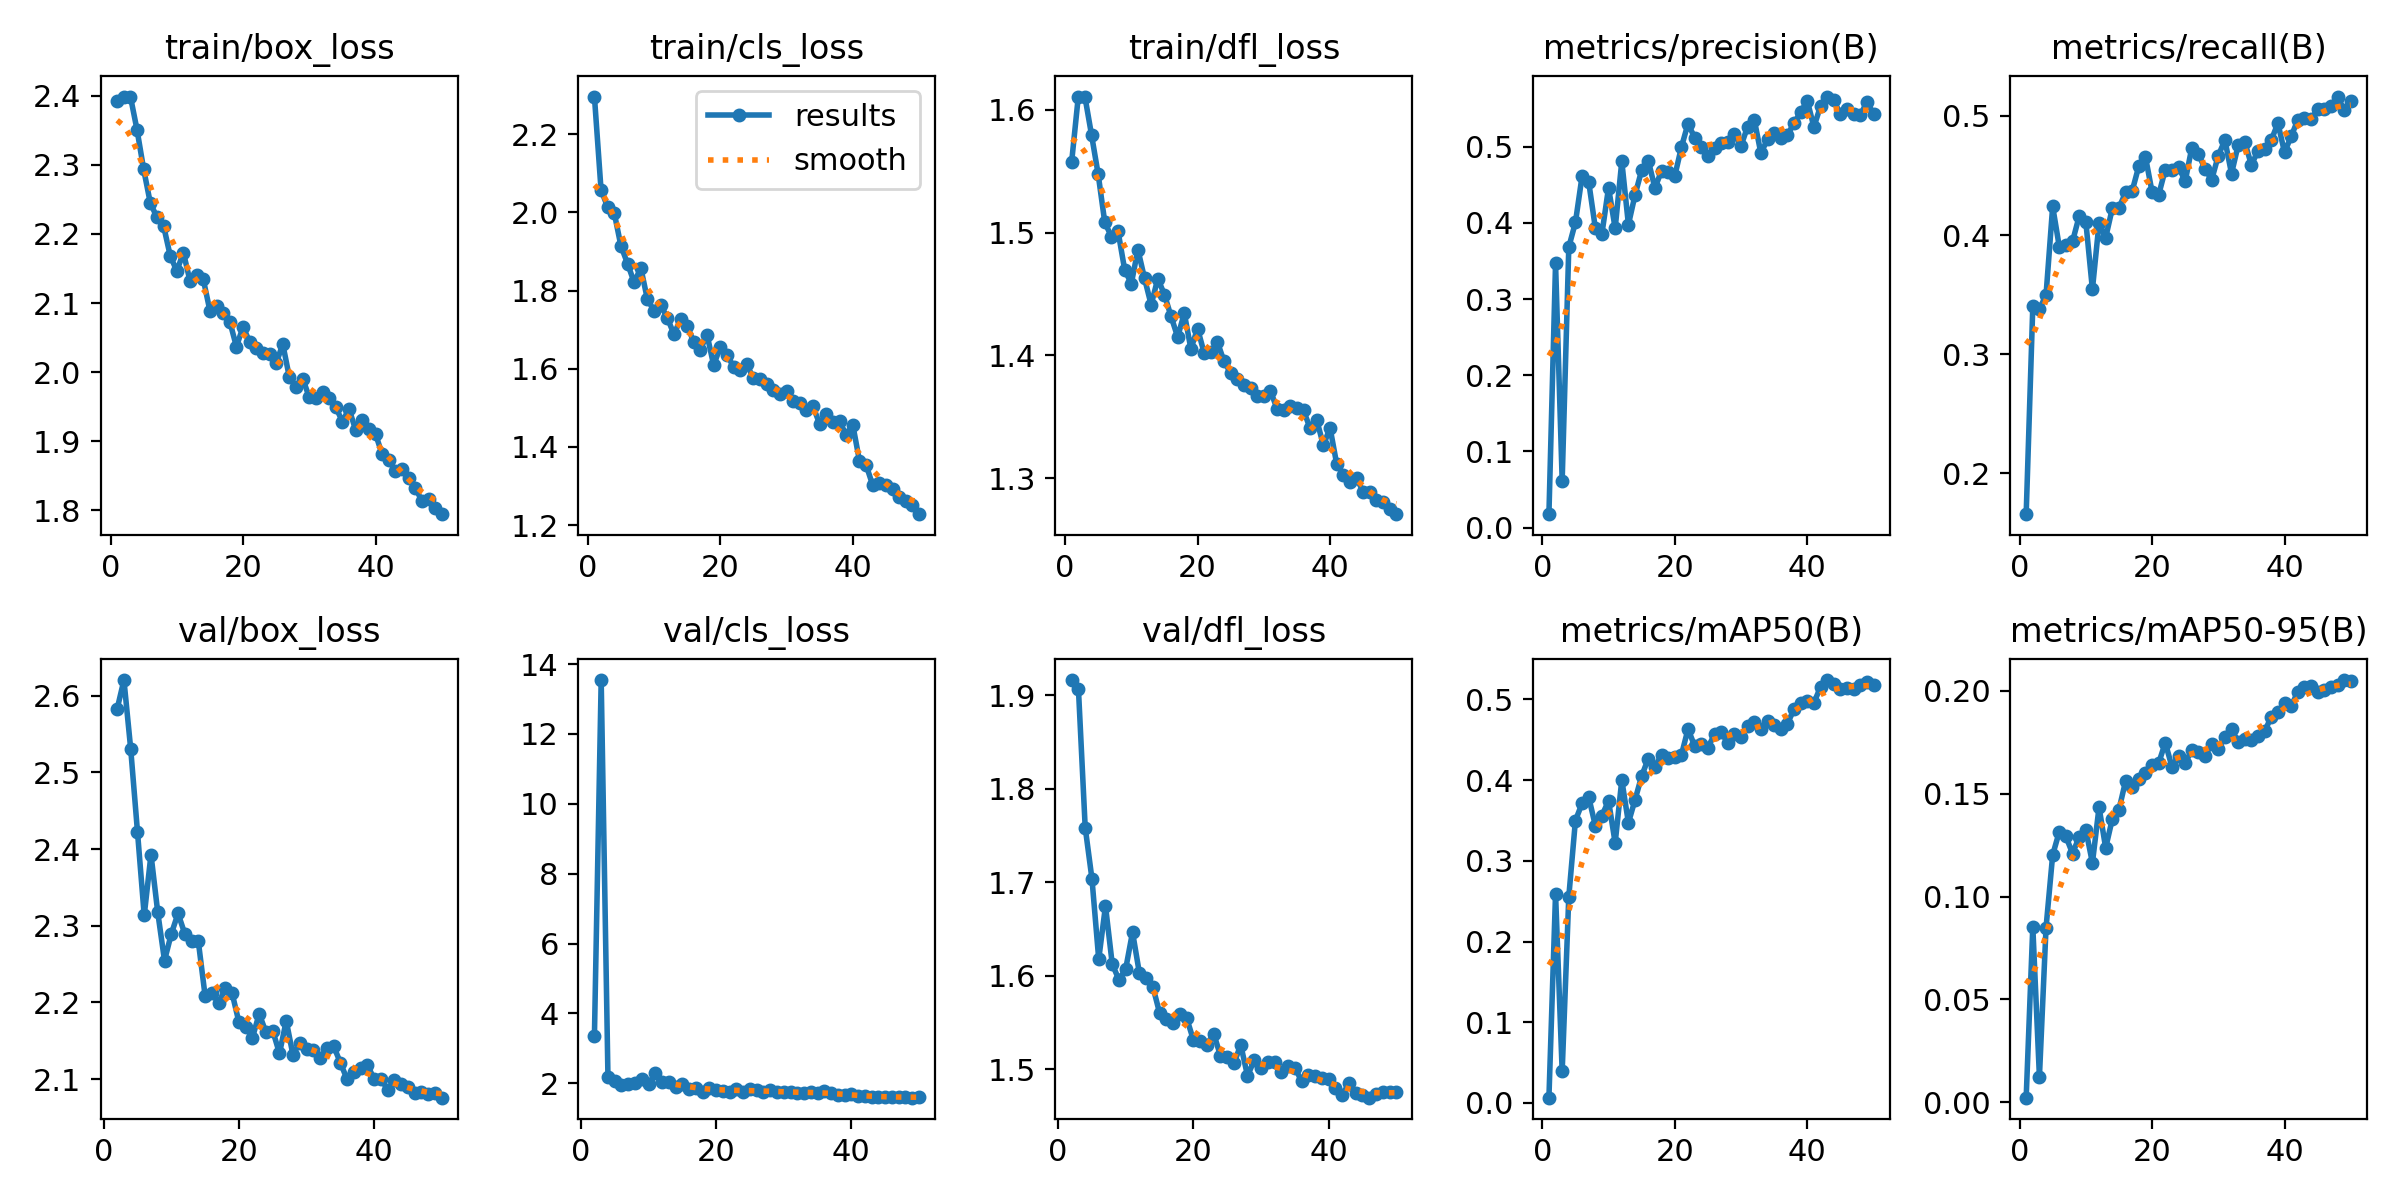

📊 Mostrando: results.png


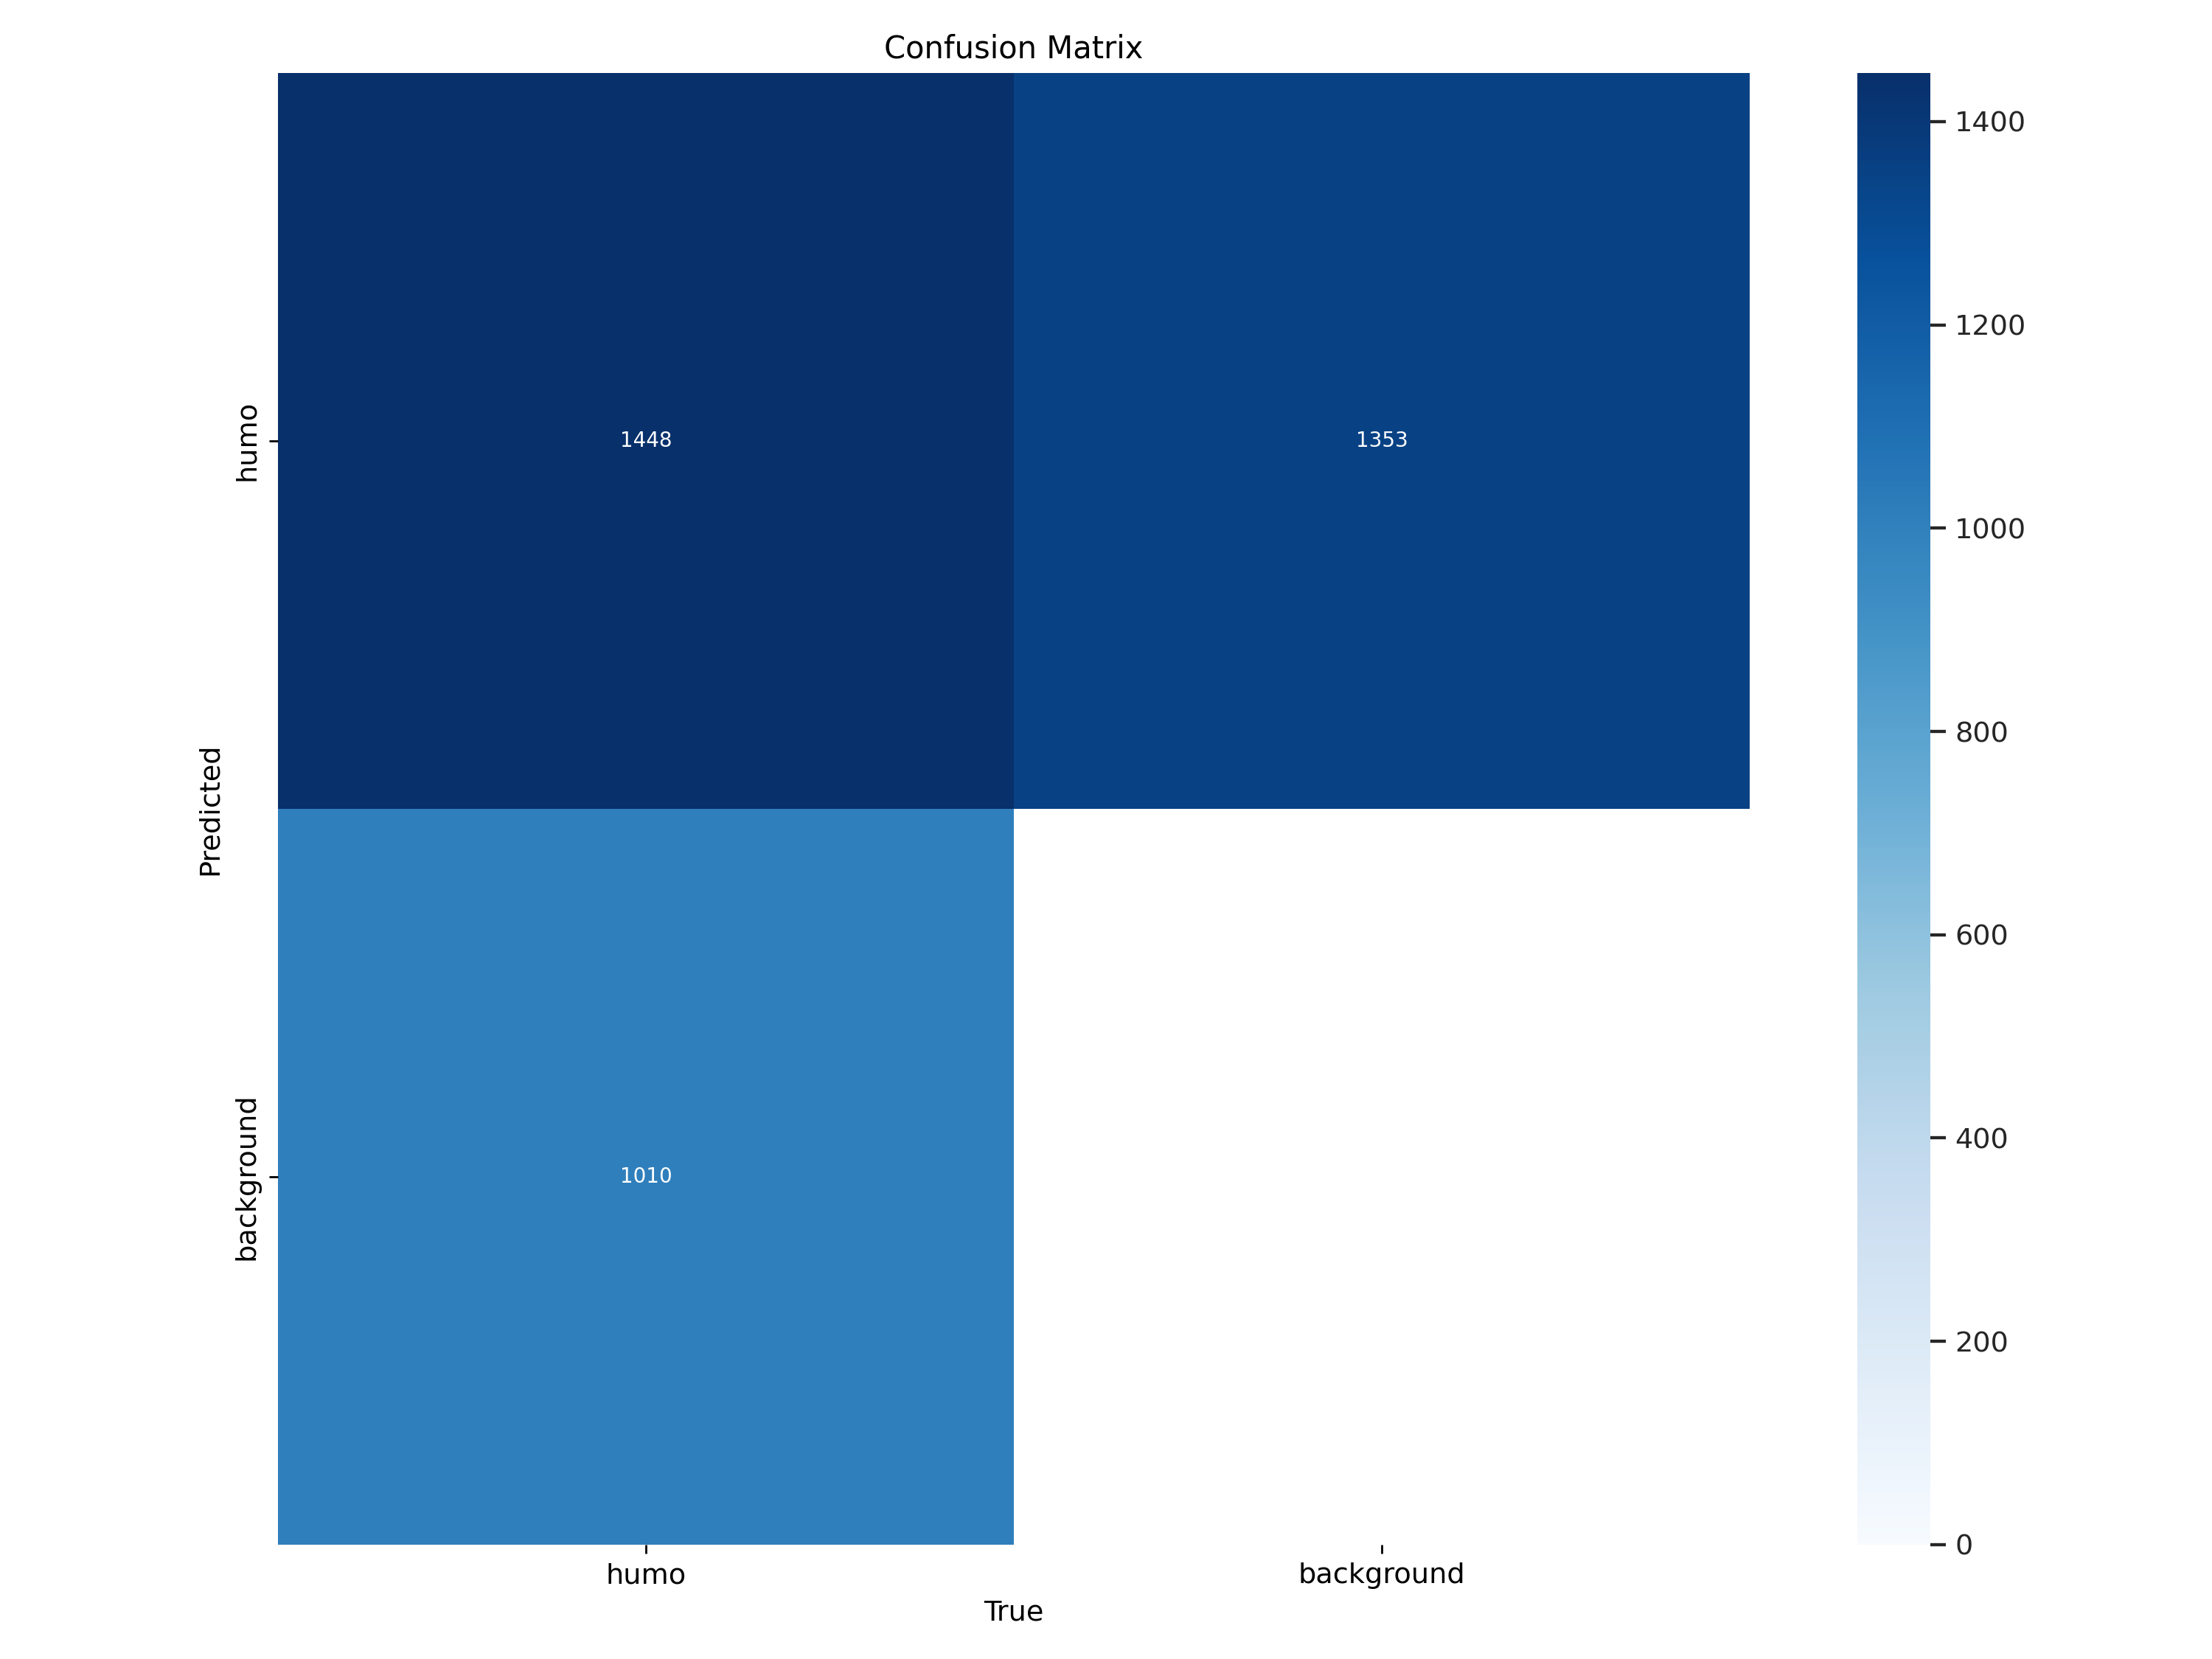

📊 Mostrando: confusion_matrix.png


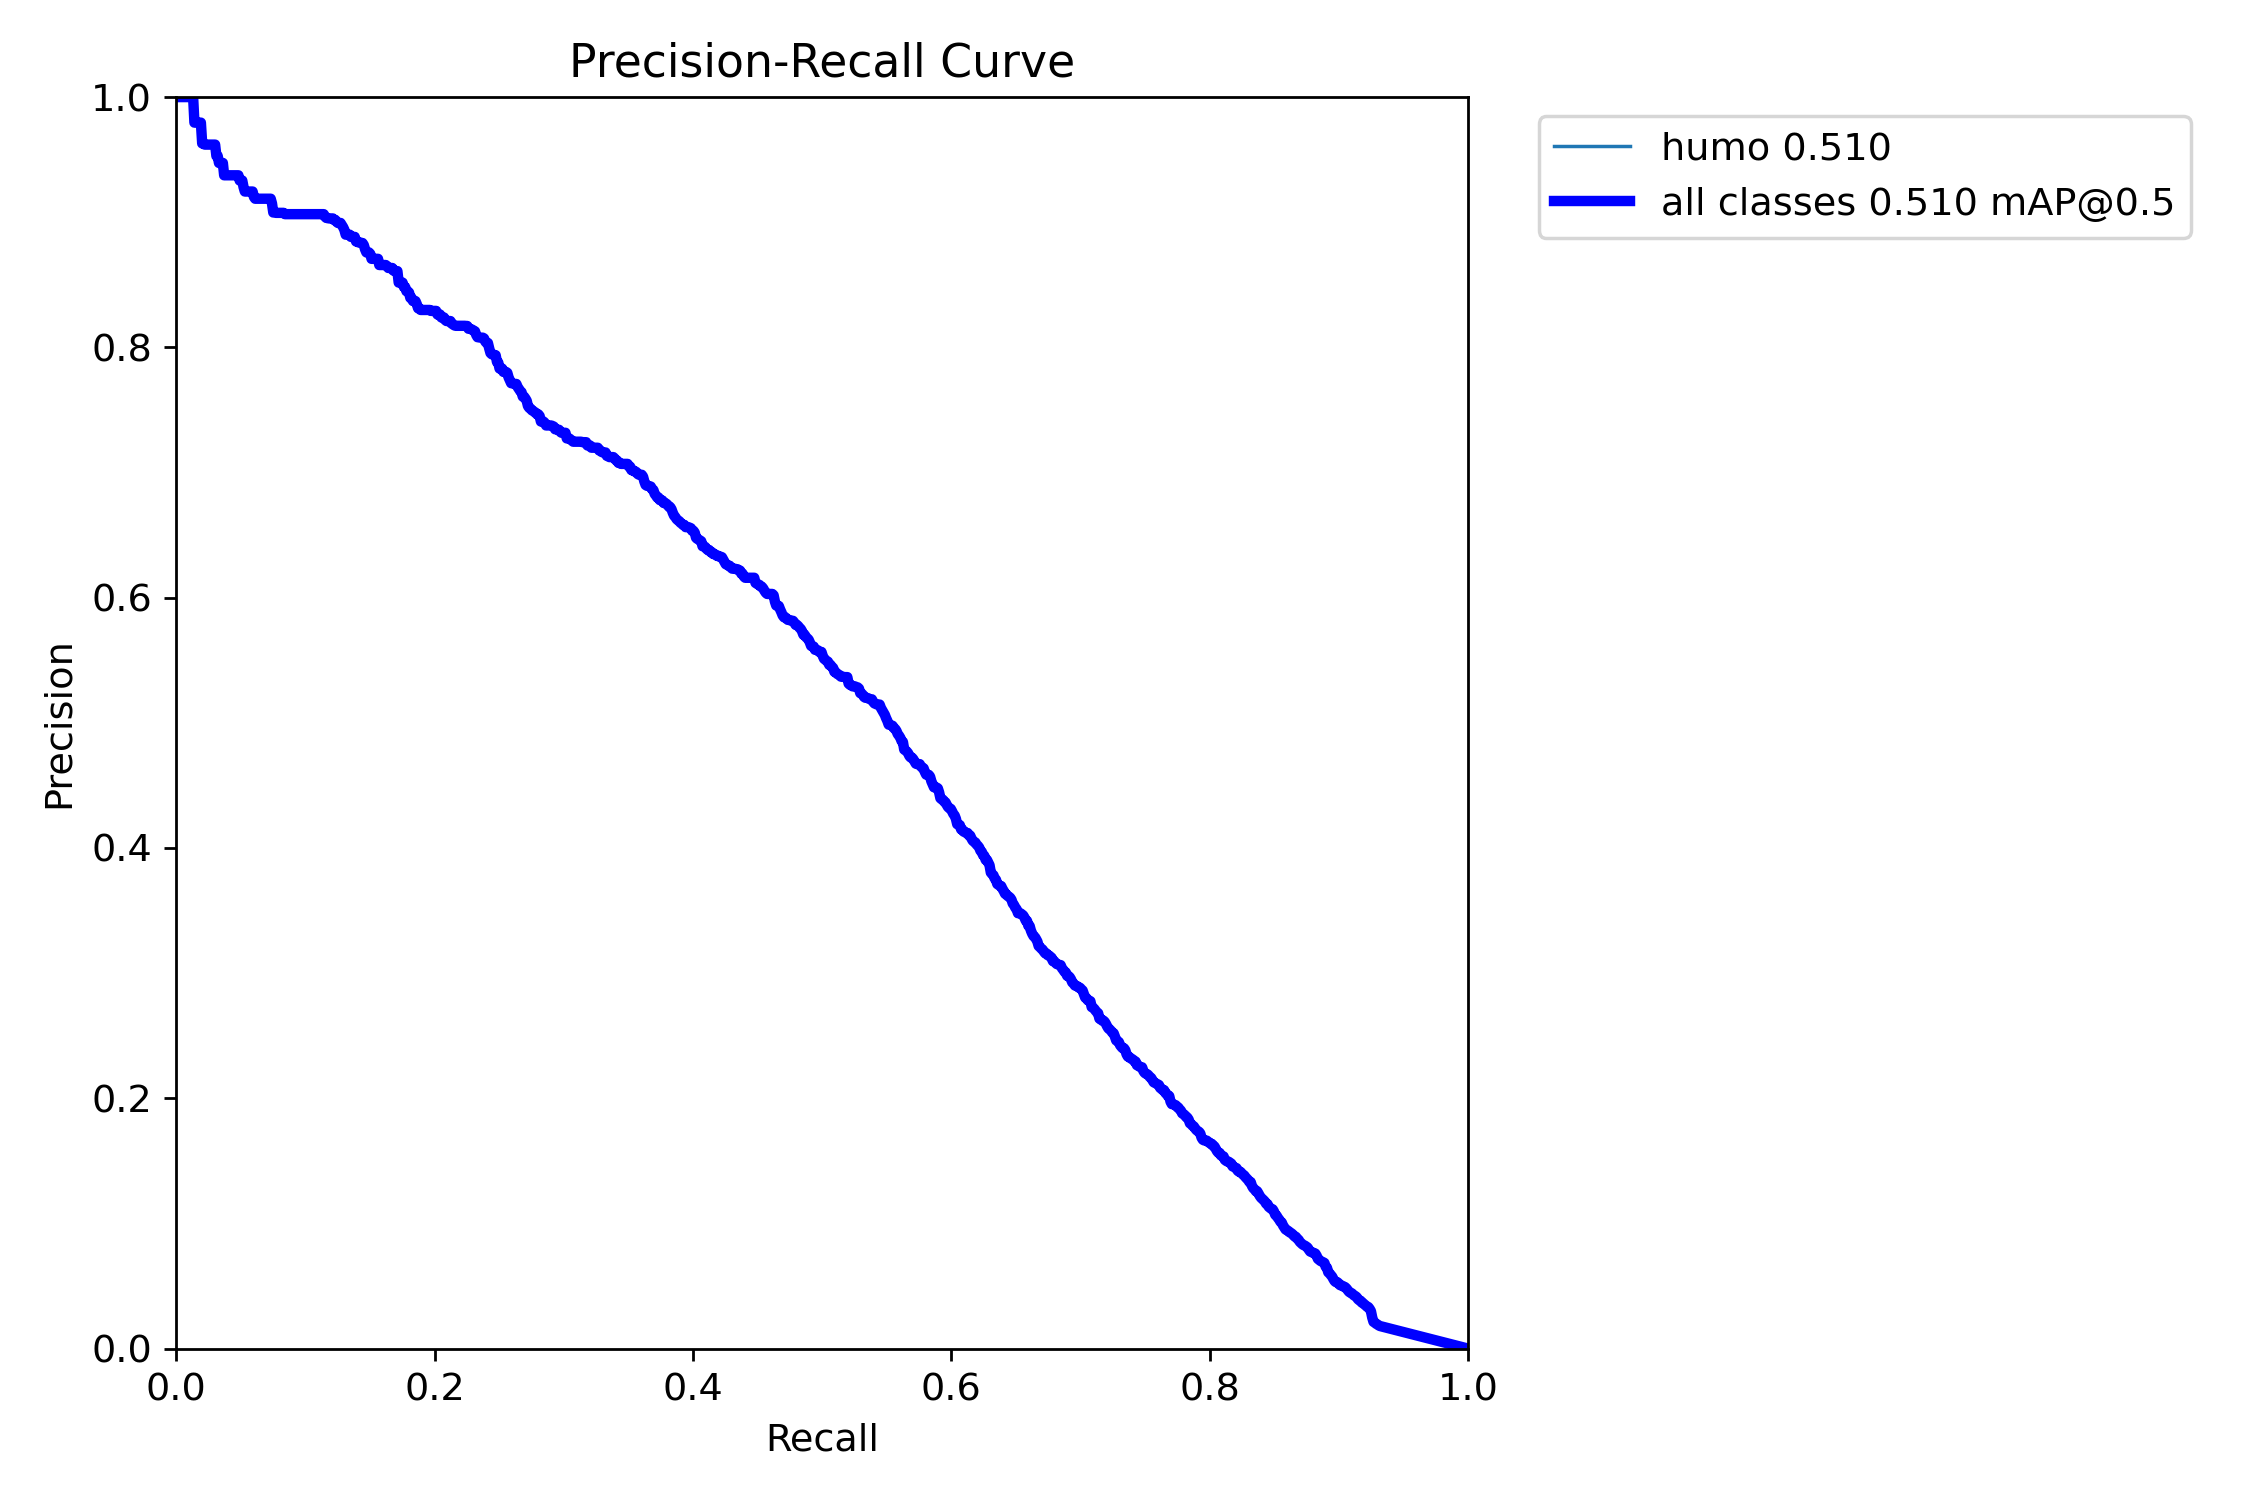

📊 Mostrando: PR_curve.png


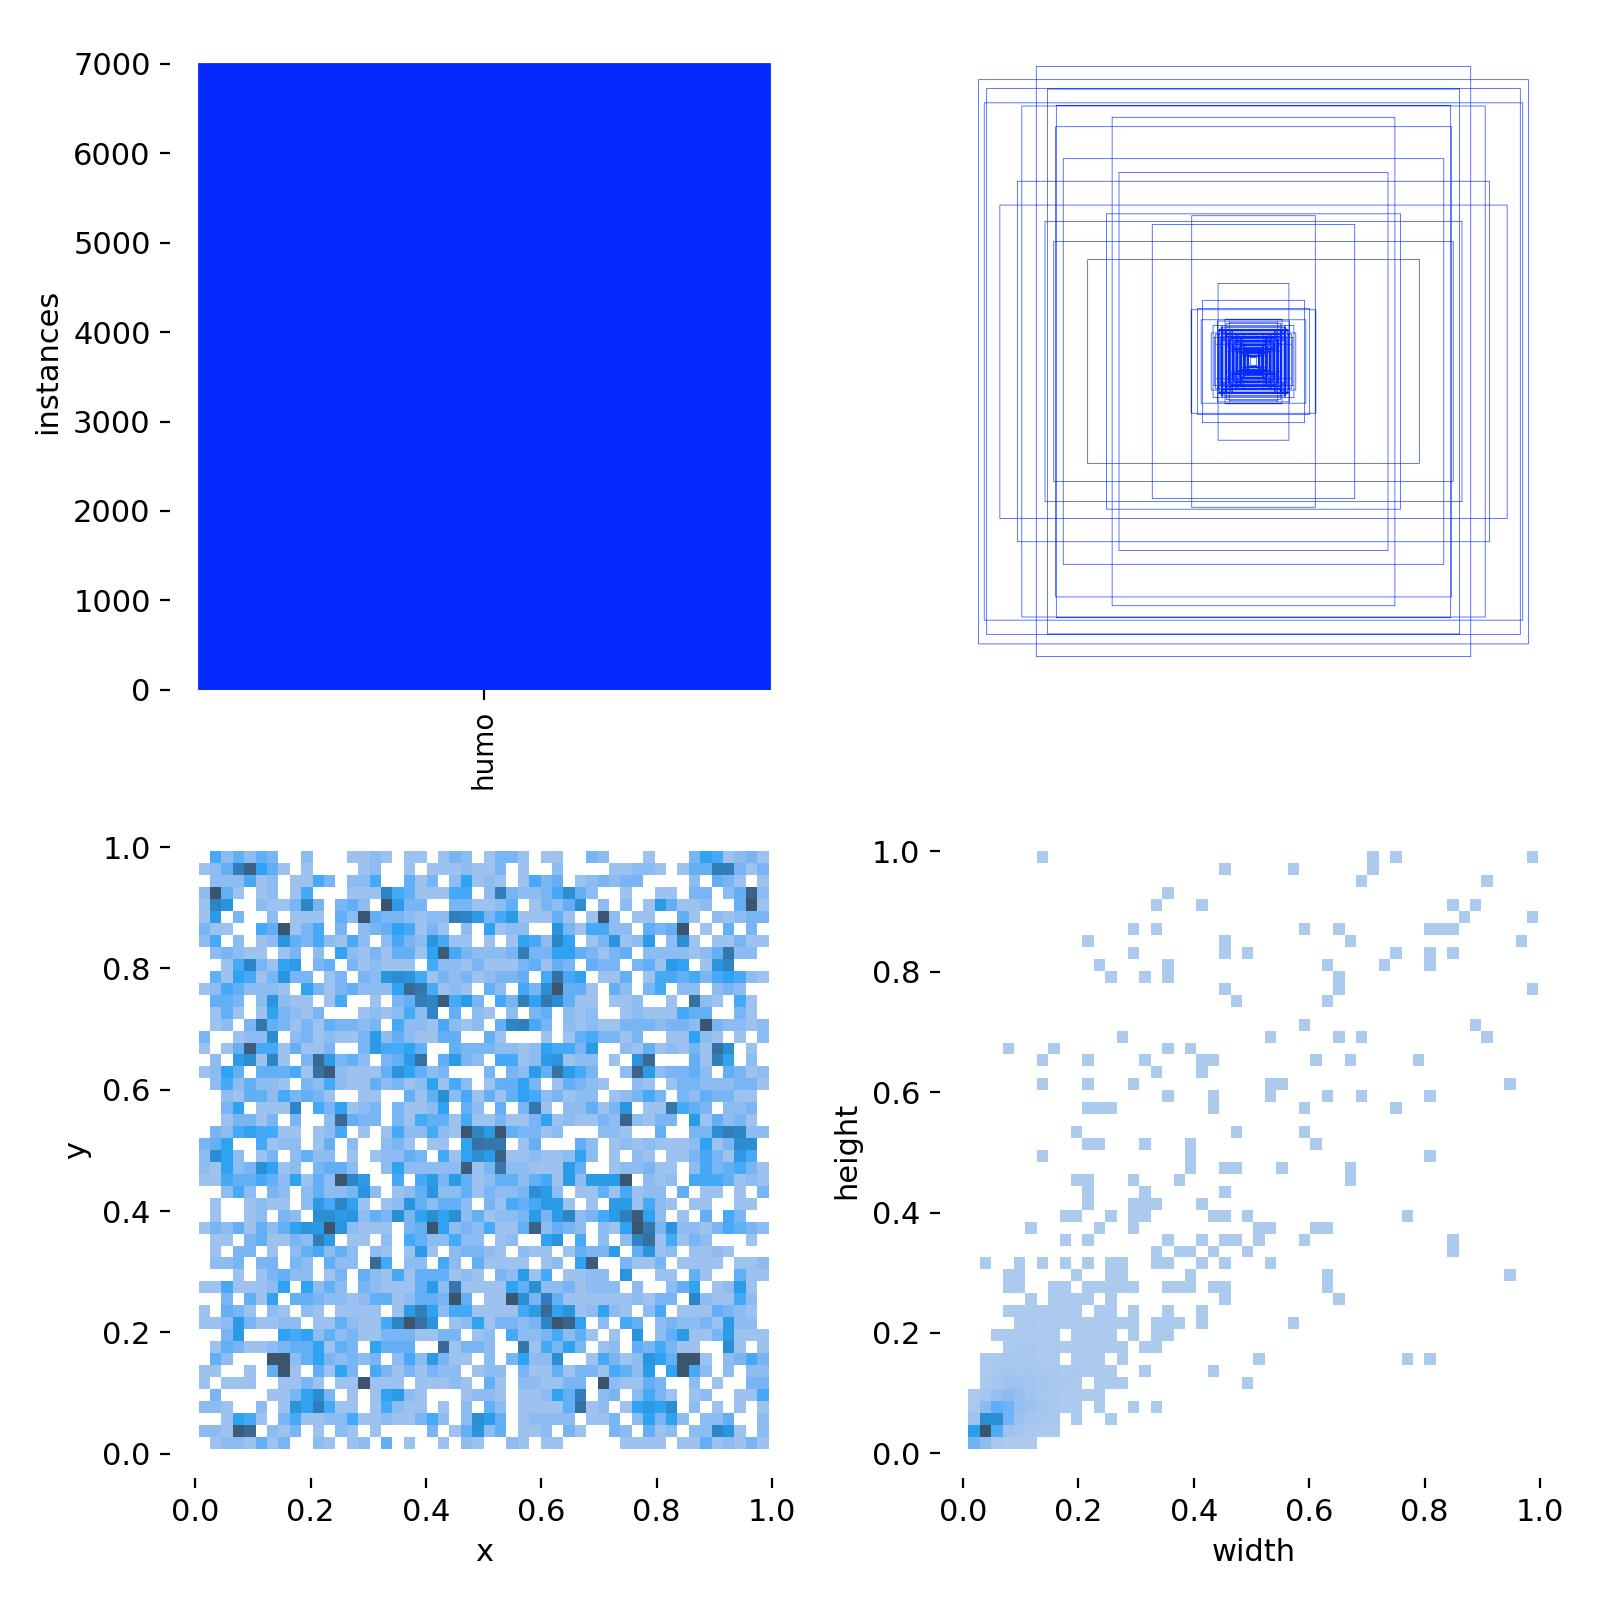

📊 Mostrando: labels.jpg


In [24]:
from IPython.display import Image, display

# Ruta base del experimento (ajustá si usaste otro nombre de run)
base_path = 'runs/detect/wildfire-augmented-v1/'

images = [
    'results.png',             # curvas de loss, precision, recall, mAP
    'confusion_matrix.png',    # matriz de confusión
    'PR_curve.png',            # curva precisión-recall
    'labels.jpg'               # distribución de etiquetas por clase
]

# Mostrar las gráficas disponibles
for img_name in images:
    img_path = base_path + img_name
    display(Image(filename=img_path))
    print(f"📊 Mostrando: {img_name}")